### Importing important libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from scipy.stats import chi2_contingency
from scipy.stats import probplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

### Few helper functions that will be used later

In [2]:
# A function that will help calculate rmse
def rmse(Y_true,Y_pred):
    rmse  = np.sqrt(mean_squared_error(Y_true,Y_pred))
    return rmse

### Loading the train data

In [3]:
data = pd.read_csv('TRAIN.csv')
data.shape

(100000, 9)

In [4]:
data.head()

,index,time_stamp,cab_provider,source,destination,distance,surge_multiplier,cab_type,fare
0,0,1543203646318,Lyft,Boston University,Theatre District,3.03,1.0,Lux Black XL,34.0
1,1,1543203646319,Uber,South Station,Theatre District,1.30,1.0,Black,18.5
2,2,1543203646320,Uber,Theatre District,Fenway,2.71,1.0,UberX,19.5
3,3,1543203646320,Lyft,Northeastern University,Beacon Hill,2.43,1.0,Lyft,10.5
4,4,1543203646320,Uber,Theatre District,Fenway,2.71,1.0,UberXL,32.0


### About the dataset

TRAIN.csv consists of 9 attributes:
- index
- time_stamp - epoch time (in milliseconds) when the cab was booked
- cab_provider - company (Uber/Lyft)
- source - the starting point of the cab ride
- destination - the destination of the cab ride
- distance - the distance between source and destination
- surge_multiplier - multiplier by which price increased
- cab_type - the type of cab (Uber Pool, Uber XL, etc. )
- fare - cab fare in USD (Target Attribute)

In [5]:
# Manipulatig the time_stamp feature in column to generate new features

# Training data
data['time_stamp'] = data['time_stamp']/1000
date_time = []
for i in range(data.shape[0]):
    temp = datetime.utcfromtimestamp(data.time_stamp[i]).strftime('%Y-%m-%d %H:%M:%S')
    date_time.append(temp)
data['date_time'] = date_time
data['date_time'] = pd.to_datetime(data['date_time'],infer_datetime_format=True)
data['year'] = data.date_time.dt.year
data['month'] = data.date_time.dt.month
data['date'] = data.date_time.dt.day
data['weekday'] = data.date_time.dt.weekday
data['hour'] = data.date_time.dt.hour
data['minute'] = data.date_time.dt.minute
data['second'] = data.date_time.dt.second

In [6]:
data.head()

,index,time_stamp,cab_provider,source,destination,distance,surge_multiplier,cab_type,fare,date_time,year,month,date,weekday,hour,minute,second
0,0,1.543204e+09,Lyft,Boston University,Theatre District,3.03,1.0,Lux Black XL,34.0,2018-11-26 03:40:46,2018,11,26,0,3,40,46
1,1,1.543204e+09,Uber,South Station,Theatre District,1.30,1.0,Black,18.5,2018-11-26 03:40:46,2018,11,26,0,3,40,46
2,2,1.543204e+09,Uber,Theatre District,Fenway,2.71,1.0,UberX,19.5,2018-11-26 03:40:46,2018,11,26,0,3,40,46
3,3,1.543204e+09,Lyft,Northeastern University,Beacon Hill,2.43,1.0,Lyft,10.5,2018-11-26 03:40:46,2018,11,26,0,3,40,46
4,4,1.543204e+09,Uber,Theatre District,Fenway,2.71,1.0,UberXL,32.0,2018-11-26 03:40:46,2018,11,26,0,3,40,46


 **Making an additional feature 'route' that provides information about the route from a particular source to a specified destination**

In [7]:
# Train data
Route = []

for i in range(data.shape[0]):
    temp = data.source[i] +"_"+ data.destination[i]
    Route.append(temp)

data['route'] = Route

### Exploratory Data Analysis

Dropping few extra columns

In [8]:
data.drop(['index','time_stamp','date_time'],axis=1,inplace=True)

In [9]:
data.head()

,cab_provider,source,destination,distance,surge_multiplier,cab_type,fare,year,month,date,weekday,hour,minute,second,route
0,Lyft,Boston University,Theatre District,3.03,1.0,Lux Black XL,34.0,2018,11,26,0,3,40,46,Boston University_Theatre District
1,Uber,South Station,Theatre District,1.30,1.0,Black,18.5,2018,11,26,0,3,40,46,South Station_Theatre District
2,Uber,Theatre District,Fenway,2.71,1.0,UberX,19.5,2018,11,26,0,3,40,46,Theatre District_Fenway
3,Lyft,Northeastern University,Beacon Hill,2.43,1.0,Lyft,10.5,2018,11,26,0,3,40,46,Northeastern University_Beacon Hill
4,Uber,Theatre District,Fenway,2.71,1.0,UberXL,32.0,2018,11,26,0,3,40,46,Theatre District_Fenway


### Checking for null values in train and test data

In [10]:
data.isnull().sum()

cab_provider        0
source              0
destination         0
distance            0
surge_multiplier    0
cab_type            0
fare                0
year                0
month               0
date                0
weekday             0
hour                0
minute              0
second              0
route               0
dtype: int64

**Observation:** Both train and test data doesn't have any null values

In [11]:
# Checking for different values of year feature
print(data.year.value_counts())
# Checking for different values of month feature
print(data.month.value_counts())

2018    100000
Name: year, dtype: int64
11    100000
Name: month, dtype: int64


**Observation:** All the data is recorded in the year 2018 in the month of November

In [12]:
# Checking for different values of date feature
print(data.date.value_counts())

27    70135
26    29028
28      837
Name: date, dtype: int64


**Observation:** The training data comprises of records from three dates namely 26,27,28 and test data comprises of records taken from 28 November

**Different cab providers and total rides provided by them in the city**

In [13]:
print(data.cab_provider.value_counts())
cab_providers =  data["cab_provider"].value_counts().index.tolist()
market_share =  data["cab_provider"].value_counts().values.tolist()

# function to calculate percentage share of each cab provider 
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.2f}%".format(pct, absolute)

Uber    51863
Lyft    48137
Name: cab_provider, dtype: int64


**Observation:** So, there are two cab providing companies **Uber** and **Lyft** and in the three days total rides provided by them are mentioned above. 

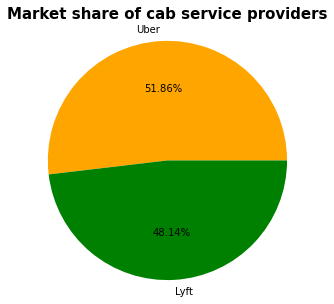

In [14]:
plt.figure(figsize=(5,5))
plt.title("Market share of cab service providers",loc='center',fontdict={'fontsize':15,'fontweight':'bold','color':'black'})
plt.pie(market_share,labels=cab_providers,radius=1.1,autopct = lambda pct: func(pct, market_share),colors=['orange','green'])
plt.show()

**Different types of cabs running in the city**

In [15]:
cab_type = data.cab_type.unique().tolist()
print("Different types of cabs operating in the city are: ")
for i in cab_type:
    print(i)

Different types of cabs operating in the city are: 
Lux Black XL
Black
UberX
Lyft
UberXL
WAV
Shared
Lux
Lux Black
Black SUV
UberPool
Lyft XL


**Distribution of Total rides w.r.t Date**

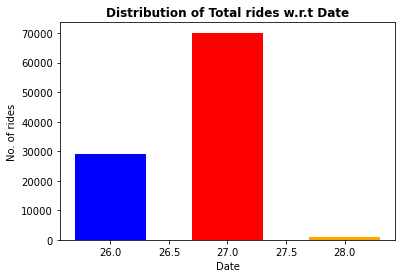

In [16]:
dates = data.date.value_counts().index.tolist()
total_rides = data.date.value_counts().values.tolist()
plt.bar(x=dates,height=total_rides,width=0.6,color=['red','blue','orange'])
plt.title("Distribution of Total rides w.r.t Date",fontdict={'fontsize':12,'fontweight':'bold','color':'black'})
plt.xlabel("Date")
plt.ylabel("No. of rides")
plt.show()

#### Different fleets and the fare charged by then

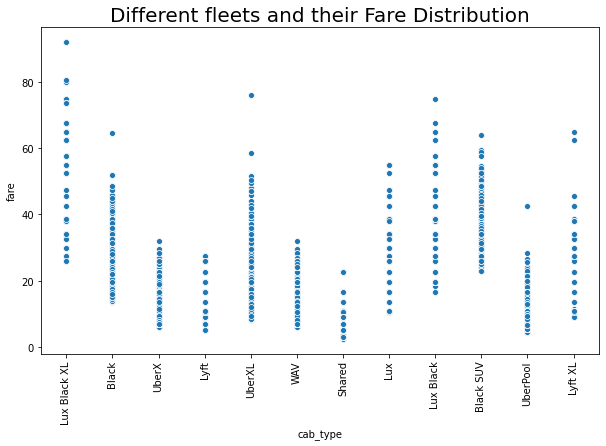

In [17]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="cab_type",y="fare",data=data)
plt.xticks(rotation=90)
plt.title("Different fleets and their Fare Distribution",fontdict={'color':'Black','fontsize':20})
plt.show()

**Observation:** We can observe that fleets that are large in size (like Lux Black XL, Lyft XL, Uber XL) generally have higher fare as compared to compact fleets like (Shared, Uber Pool, Lyft) 

## Some Uber specific insights from the data

**Different types of fleets run by Uber and total rides completed by them**

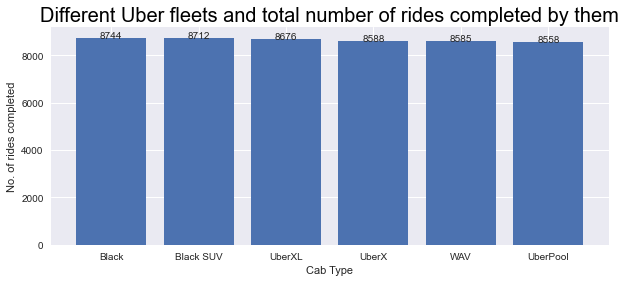

In [18]:
# No. of rides operated by different fleets of Uber
Uber_df = data.loc[data.cab_provider == 'Uber']
Uber_cab_names = Uber_df.cab_type.value_counts().index.tolist()
Uber_cab_count = Uber_df.cab_type.value_counts().values.tolist()

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

plt.figure(figsize=(10,4))
plt.style.use('seaborn')
# making the bar chart on the data
plt.bar(Uber_cab_names, Uber_cab_count)
plt.title("Different Uber fleets and total number of rides completed by them",fontdict={'color':'Black','fontsize':20})
# calling the function to add value labels
addlabels(Uber_cab_names, Uber_cab_count)
plt.xlabel("Cab Type")
plt.ylabel("No. of rides completed")
plt.show()

In [19]:
# Distribution of surge multipliers
Uber_df.surge_multiplier.value_counts()

1.0    51863
Name: surge_multiplier, dtype: int64

**Observation:** This signifies that Uber is operating with only a single surge multiplier value of 1.

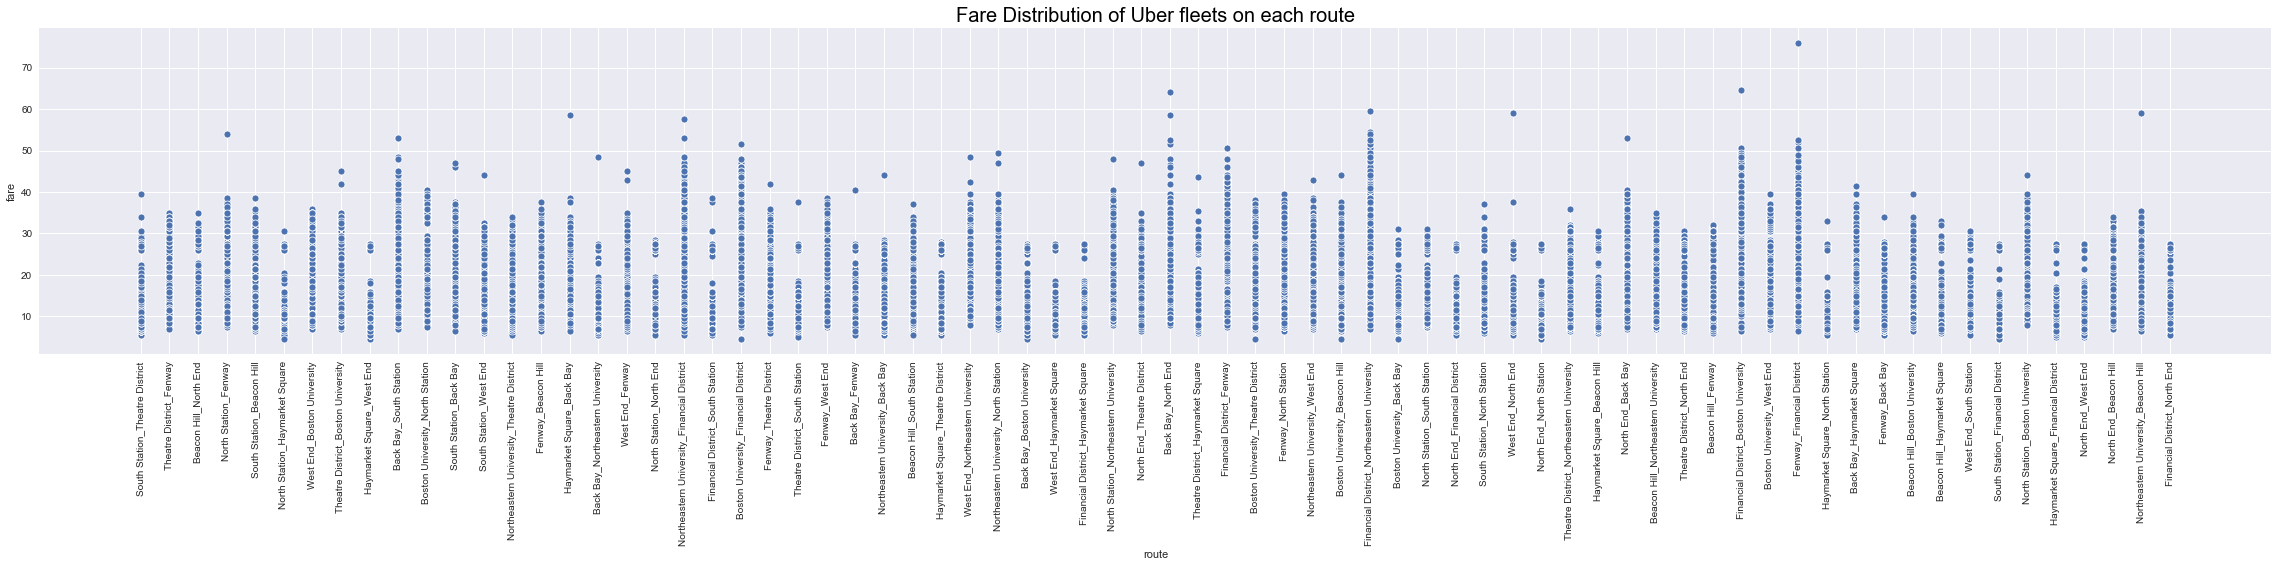

In [20]:
plt.figure(figsize=(40,6))
sns.scatterplot(x="route",y="fare",data=Uber_df)
plt.xticks(rotation=90)
plt.title("Fare Distribution of Uber fleets on each route",fontdict={'color':'Black','fontsize':20})
plt.show()

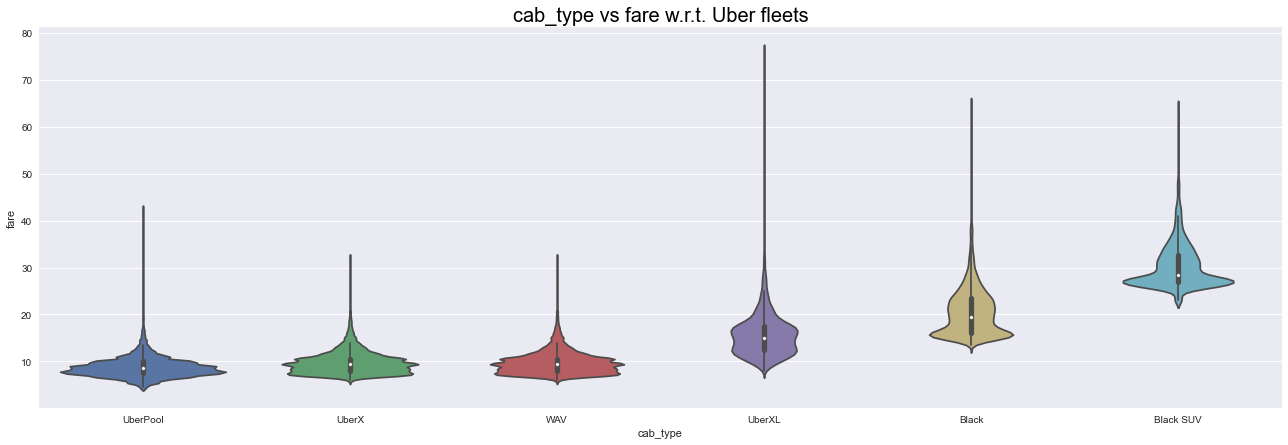

In [21]:
# cab_type vs fare
sns.catplot(y = "fare", x = "cab_type", data = Uber_df.sort_values("fare", ascending = True), kind="violin", height = 6, aspect = 3)
plt.title("cab_type vs fare w.r.t. Uber fleets",fontdict={'color':'Black','fontsize':20})
plt.show()

**Observation**: Large size vehicles have higher fare

# Some Lyft specific insights from the data

**Different types of fleets run by Lyft and total rides completed by them**

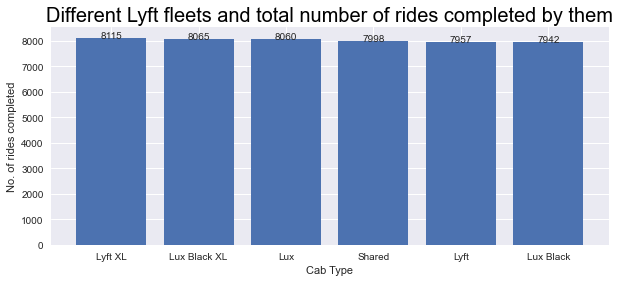

In [22]:
# No. of rides operated by different fleets of Lyft

Lyft_df = data.loc[data.cab_provider == 'Lyft']
Lyft_cab_names = Lyft_df.cab_type.value_counts().index.tolist()
Lyft_cab_count = Lyft_df.cab_type.value_counts().values.tolist()

plt.figure(figsize=(10,4))
plt.style.use('seaborn')
# making the bar chart on the data
plt.bar(Lyft_cab_names, Lyft_cab_count)
plt.title("Different Lyft fleets and total number of rides completed by them",fontdict={'color':'Black','fontsize':20})
# calling the function to add value labels
addlabels(Lyft_cab_names, Lyft_cab_count)
plt.xlabel("Cab Type")
plt.ylabel("No. of rides completed")
plt.show()

In [23]:
# Distribution of surge multipliers
Lyft_df.surge_multiplier.value_counts()

1.00    44890
1.25     1715
1.50      764
1.75      403
2.00      337
2.50       23
3.00        5
Name: surge_multiplier, dtype: int64

**Observation:** This signifies that Lyft is operating with different surge multiplier values ranging from 1 to 3.

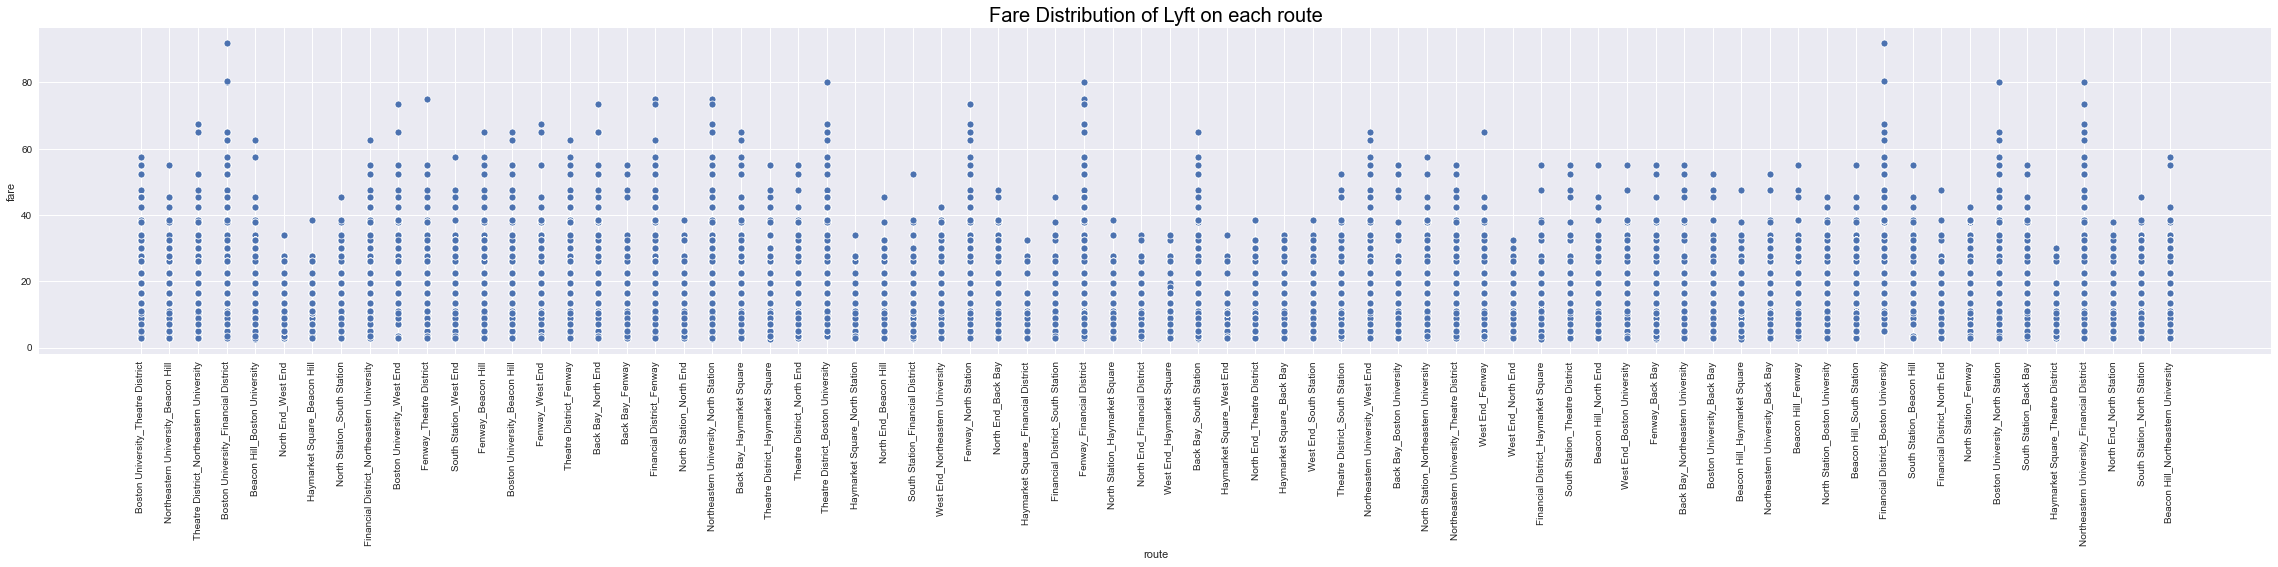

In [24]:
plt.figure(figsize=(40,6))
sns.scatterplot(x="route",y="fare",data=Lyft_df)
plt.xticks(rotation=90)
plt.title("Fare Distribution of Lyft on each route",fontdict={'color':'Black','fontsize':20})
plt.show()

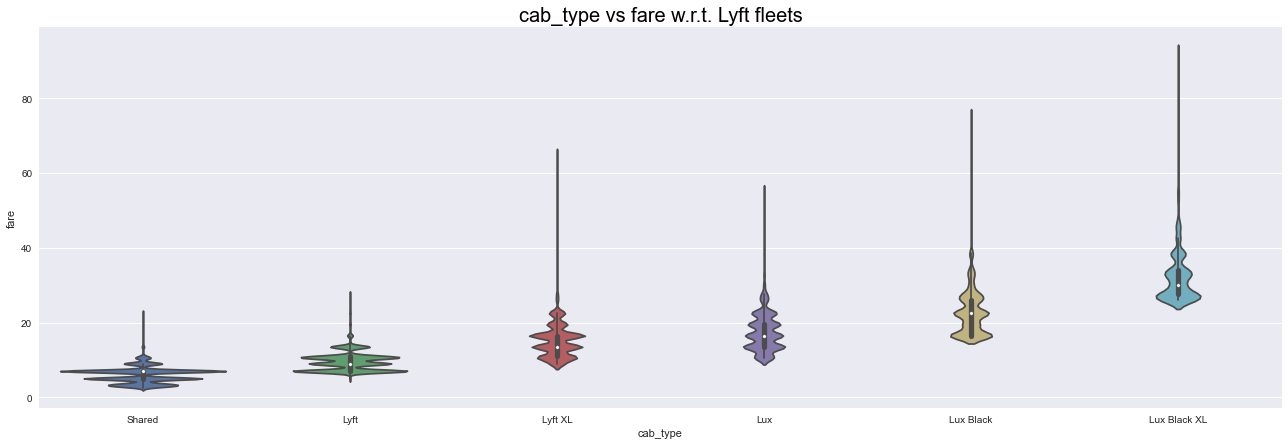

In [25]:
# cab_type vs fare
sns.catplot(y = "fare", x = "cab_type", data = Lyft_df.sort_values("fare", ascending = True), kind="violin", height = 6, aspect = 3)
plt.title("cab_type vs fare w.r.t. Lyft fleets",fontdict={'color':'Black','fontsize':20})
plt.show()

**Observations**:
- The shared cab_type costs minimum fare.
- Also, we can see premium cabs having larger size have high fare rates which is true in real world.

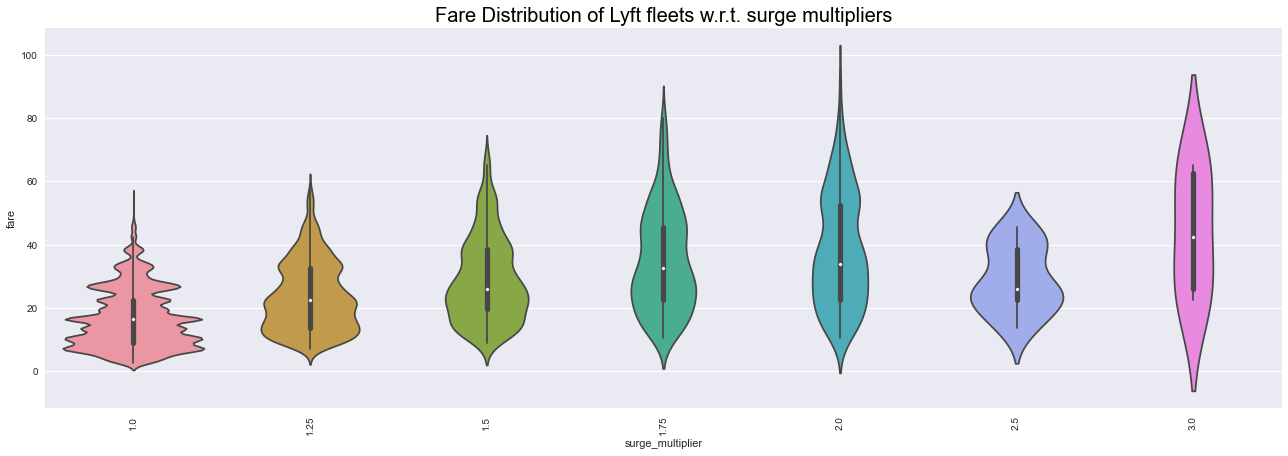

In [26]:
# fare vs surge_multiplier
sns.catplot(y="fare", x = "surge_multiplier", data = Lyft_df.sort_values("fare", ascending = True), kind="violin", height = 6, aspect = 3)
plt.xticks(rotation=90)
plt.title("Fare Distribution of Lyft fleets w.r.t. surge multipliers",fontdict={'color':'Black','fontsize':20})
plt.show()

**Observation:** When the value of surge_multiplier increases fare value has also increased.

In [27]:
# Dropping some more features from the dataset
data.drop(['year','month','date','hour','minute','second','weekday','route'],axis=1,inplace=True)

In [28]:
data.head()

,cab_provider,source,destination,distance,surge_multiplier,cab_type,fare
0,Lyft,Boston University,Theatre District,3.03,1.0,Lux Black XL,34.0
1,Uber,South Station,Theatre District,1.30,1.0,Black,18.5
2,Uber,Theatre District,Fenway,2.71,1.0,UberX,19.5
3,Lyft,Northeastern University,Beacon Hill,2.43,1.0,Lyft,10.5
4,Uber,Theatre District,Fenway,2.71,1.0,UberXL,32.0


In [29]:
numerical_feats = ['fare','distance']
categorical_feats = ['source','destination','cab_provider','surge_multiplier','cab_type']

### Univariate Analysis

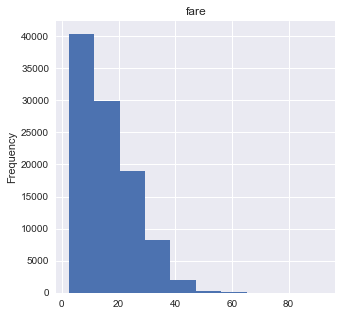

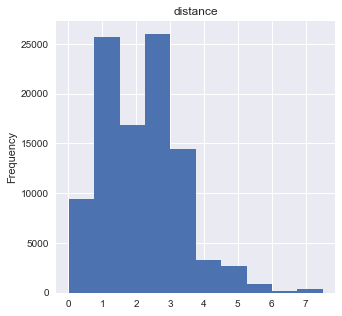

In [30]:
for i in numerical_feats:
    plt.figure(figsize=(5,5))
    plt.title(i)
    data[i].plot(kind='hist')
    plt.show()

**Observation:** We can notice both **distance** feature and **fare** feature are right/positively skewed. 

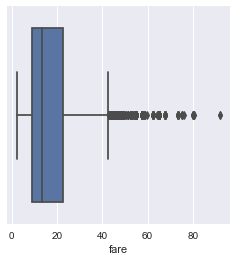

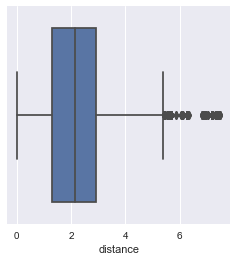

In [31]:
# Boxplot of each numerical feature
for i in numerical_feats:
    plt.figure(figsize=(4,4))
    sns.boxplot(data[i])
    plt.show()

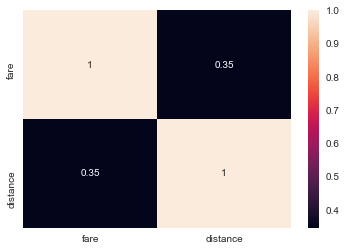

In [32]:
# Correlation plot of numerical features
plt.figure(figsize=(6,4))
sns.heatmap(data[numerical_feats].corr(), annot=True)
plt.show()

**Observation:** Fare is positively correlated with Distance, that means as distance increases fare will also increase and when distance will decrease fare will also decrease. 

### Bivariate analysis of different features

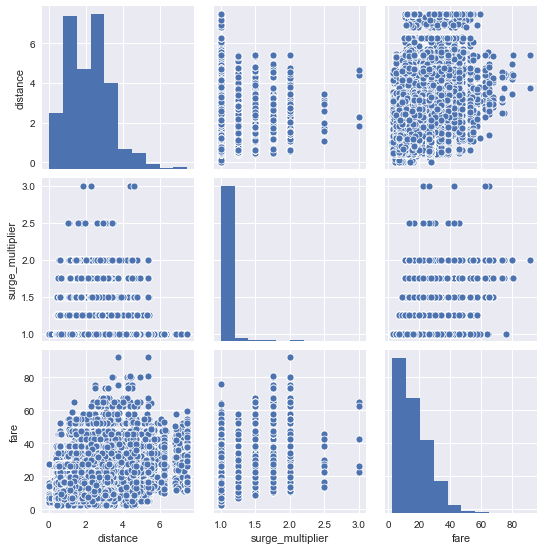

In [33]:
sns.pairplot(data)
plt.show()

**In the below joint plot**
Scatter plot has regression line between 2 variables along with separate Bar plots of both variables.
Also its annotated with pearson correlation coefficient and p value.

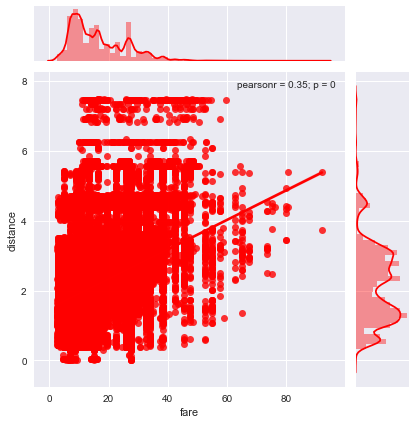

In [34]:
# Joint plot for fare vs distance
jpt = sns.jointplot(x='fare',y='distance',data=data,kind = 'reg',color='red',)
jpt.annotate(stats.pearsonr)
plt.show()

### Chi-square test of Independence for Categorical Variables/Features
**Hypothesis testing :**

**Null Hypothesis:** Both categorical variables are independent.

**Alternate Hypothesis:** Both categorical variables are not independent.

If p-value is less than 0.05 then we reject the null hypothesis saying that 2 variables are dependent.

And if p-value is greater than 0.05 then we accept the null hypothesis saying that 2 variables are independent.

Generally, there should be no dependencies between Independent variables.

In [35]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

for i in range(len(categorical_feats)):
    for j in range(i+1,len(categorical_feats)):
        
        chi_2_stats, p, dof, expected = chi2_contingency(pd.crosstab(data[categorical_feats[i]], data[categorical_feats[j]]))
        
        prob = 0.95
        
        '''
        # interprete test-statistic
        critical_value = chi2.ppf(prob, dof)
        
        if abs(chi_2_stats) >= critical_value:
            print('Features %s and %s are dependent (we can reject H0)'%(categorical_feats[i],categorical_feats[j]))
        else:
            print('Features %s and %s are independent (we cannot reject H0)'%(categorical_feats[i],categorical_feats[j]))
        '''
        # interpret p-value
        alpha = 1.0 - prob
        if p <= alpha:
            print('Features %s and %s are dependent (we can reject H0)'%(categorical_feats[i],categorical_feats[j]))
        else:
                print('Features %s and %s are independent (we cannot reject H0)'%(categorical_feats[i],categorical_feats[j]))

Features source and destination are dependent (we can reject H0)
Features source and cab_provider are dependent (we can reject H0)
Features source and surge_multiplier are dependent (we can reject H0)
Features source and cab_type are independent (we cannot reject H0)
Features destination and cab_provider are dependent (we can reject H0)
Features destination and surge_multiplier are dependent (we can reject H0)
Features destination and cab_type are independent (we cannot reject H0)
Features cab_provider and surge_multiplier are dependent (we can reject H0)
Features cab_provider and cab_type are dependent (we can reject H0)
Features surge_multiplier and cab_type are dependent (we can reject H0)


### QQ-plots of numerical/continuous features

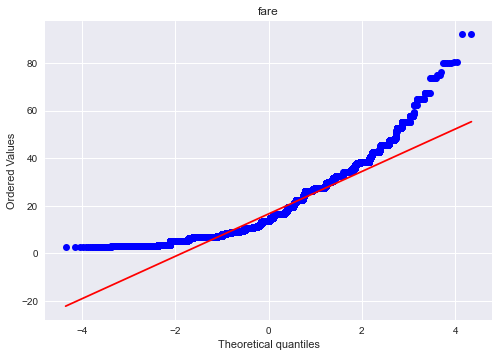

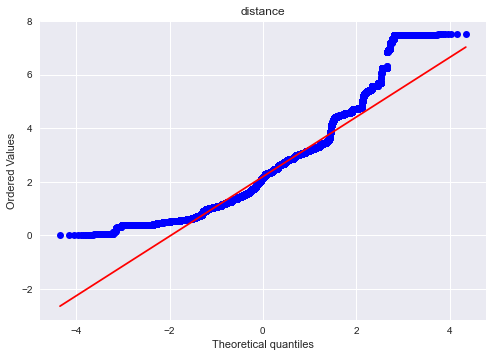

In [36]:
for i in numerical_feats:
    probplot(data[i], dist='norm', fit=True, plot=plt)
    plt.title(i)
    plt.show()

**Observation:** So, we have either very low or moderate multicollinearity amongst independent features 

### Feature Engineering

In [37]:
### Removing skewness from the dataset
data['distance'] = np.log1p(data['distance'])
data['fare'] = np.log1p(data['fare'])

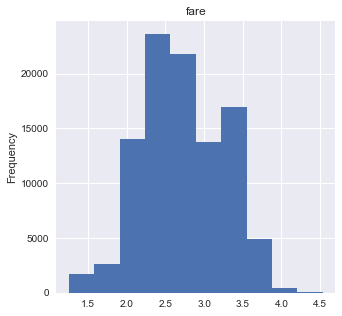

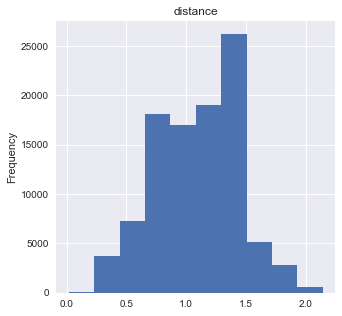

In [38]:
# Plot after removing skewness
for i in numerical_feats:
    plt.figure(figsize=(5,5))
    plt.title(i)
    data[i].plot(kind='hist')
    plt.show()

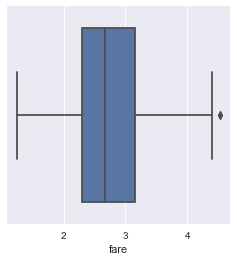

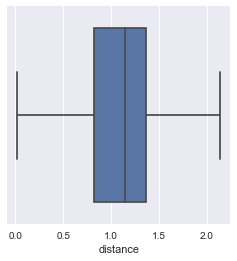

In [39]:
# Boxplot of each numerical feature after removing skewness
for i in numerical_feats:
    plt.figure(figsize=(4,4))
    sns.boxplot(data[i])
    plt.show()

In [40]:
surge_dict = { 1.0 :0, 1.25 :1, 1.5: 2,1.75: 3,2.0 : 4, 2.50: 5 ,3.00: 6 }
data['surge_multiplier'] = data['surge_multiplier'].map(surge_dict)

In [41]:
provider_dict = {'Uber':0,'Lyft':1}
data['cab_provider'] = data['cab_provider'].map(provider_dict)

In [42]:
cab_type_dict = {
    'WAV' : 0, 'UberXL'  : 1, 'UberX'   : 2, 'Black'   : 3,
'Black SUV' : 4, 'UberPool'  : 5, 'Lyft' : 6, 'Lux Black' : 7,
'Shared' : 8, 'Lyft XL' : 9, 'Lux' : 10, 'Lux Black XL' : 11
}

data['cab_type'] = data['cab_type'].map(cab_type_dict)

In [43]:
source_dict = { 'North End':0, 'Financial District' : 1,
"Theatre District": 2, "South Station" : 3, "Back Bay":4,"Haymarket Square": 5, "Northeastern University" : 6,
"Beacon Hill":7,"Fenway":8, "Boston University":9,"West End":10, "North Station":11  }

data['source'] = data['source'].map(source_dict)

In [44]:
destination_dict = { "Back Bay":0, 'North End':1, 'Financial District' : 2,
"Theatre District": 3, "North Station":4, "Fenway":5, "West End":6, "Northeastern University" : 7,
"South Station" : 8, "Boston University":9,"Haymarket Square": 10, 
"Beacon Hill":11 }

data['destination'] = data['destination'].map(destination_dict).astype('int')

In [45]:
data.head()

,cab_provider,source,destination,distance,surge_multiplier,cab_type,fare
0,1,9,3,1.393766,0,11,3.555348
1,0,3,3,0.832909,0,3,2.970414
2,0,2,5,1.311032,0,2,3.020425
3,1,6,11,1.232560,0,6,2.442347
4,0,2,5,1.311032,0,1,3.496508


### Modelling 

In [46]:
data_train = data.copy()
data_train.drop('fare',axis=1,inplace=True)

In [47]:
# Splitting of features into independent and dependent sets
X = data_train
Y = data['fare']
print(X.shape,Y.shape)

(100000, 6) (100000,)


#### 1. Linear Regression 

In [48]:
errlr = []
y_pred_totlr = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred_lr = lr.predict(X_test)
    
    print("RMSE of LR model: ", rmse(np.expm1(y_test), np.expm1(y_pred_lr)))
    
    errlr.append(rmse(np.expm1(y_test), np.expm1(y_pred_lr)))

print("RMSE of Linear regressor model is: %.3f"%np.mean(errlr,0))

RMSE of LR model:  7.725319622254802
RMSE of LR model:  7.798308532696275
RMSE of LR model:  7.844006400863365
RMSE of LR model:  7.8103138955707925
RMSE of LR model:  7.750180905290016
RMSE of LR model:  7.805380622138025
RMSE of LR model:  7.781618281481616
RMSE of LR model:  7.768645113607707
RMSE of LR model:  7.7407441784783915
RMSE of LR model:  7.771982869558249
RMSE of Linear regressor model is: 7.780


#### 2. Random Forest Regressor

In [49]:
errrf = []
y_pred_totrf = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)

    y_pred_rf = rf.predict(X_test)
    
    print("RMSE RF: ", rmse(np.expm1(y_test), np.expm1(y_pred_rf)))
    
    errrf.append(rmse(np.expm1(y_test), np.expm1(y_pred_rf)))

print("RMSE of Random Forest regressor model is: %.3f"%np.mean(errrf,0))

RMSE RF:  1.819910375467841
RMSE RF:  1.744820716740019
RMSE RF:  1.642374555816316
RMSE RF:  1.6894366069593083
RMSE RF:  1.7532564858823876
RMSE RF:  1.6840074188630931
RMSE RF:  1.6208659824770435
RMSE RF:  1.7426235780569777
RMSE RF:  1.6479575133193687
RMSE RF:  1.73013717697492
RMSE of Random Forest regressor model is: 1.708


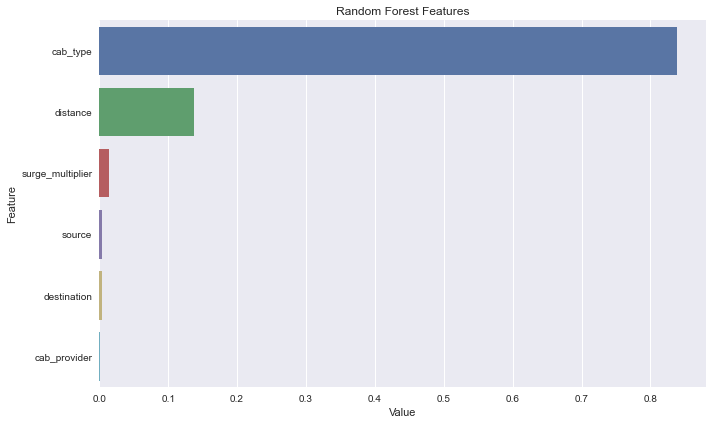

In [50]:
feature_imp = pd.DataFrame(sorted(zip(rf.feature_importances_, X.columns), reverse=True)[:30], 
                           columns=['Value','Feature'])
plt.figure(figsize=(10,6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Random Forest Features')
plt.tight_layout()
plt.show()

#### 3. Extra Tress Regressor

In [51]:
erretr = []
y_pred_totetr = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    etr = ExtraTreesRegressor(random_state=42)
    etr.fit(X_train, y_train)

    y_pred_etr = etr.predict(X_test)
    
    print("RMSE ETR: ", rmse(np.expm1(y_test), np.expm1(y_pred_etr)))
    
    erretr.append(rmse(np.expm1(y_test), np.expm1(y_pred_etr)))
    
print("RMSE of Extra Trees regressor model is: %.3f"%np.mean(erretr,0))

RMSE ETR:  1.8335334781044952
RMSE ETR:  1.7752285291865066
RMSE ETR:  1.6711195347361973
RMSE ETR:  1.69912872720307
RMSE ETR:  1.7844676004746813
RMSE ETR:  1.7153616039784263
RMSE ETR:  1.64283932107515
RMSE ETR:  1.7721702446117886
RMSE ETR:  1.6722858115657078
RMSE ETR:  1.7588646264392647
RMSE of Extra Trees regressor model is: 1.732


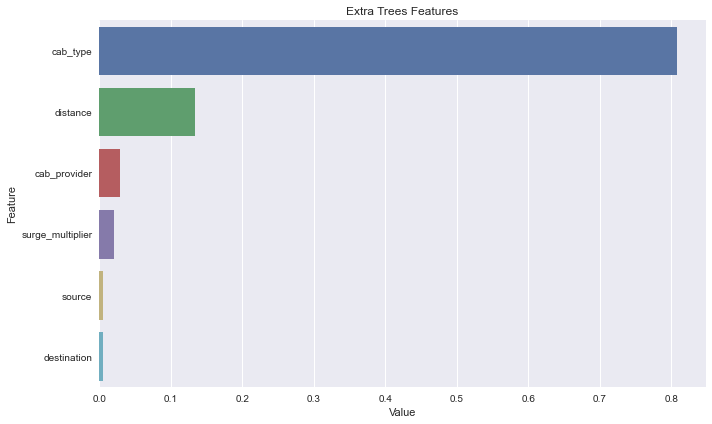

In [52]:
feature_imp = pd.DataFrame(sorted(zip(etr.feature_importances_, X.columns), reverse=True)[:30], 
                           columns=['Value','Feature'])
plt.figure(figsize=(10,6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Extra Trees Features')
plt.tight_layout()
plt.show()

#### 4. Gradient Boosting Regressor

In [53]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor

errgbr = []
y_pred_totgbr = []

fold = KFold(n_splits=10, shuffle=True, random_state=1)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
             
    gbr = GradientBoostingRegressor(subsample = 0.6, n_estimators = 1250, min_samples_split = 4, min_samples_leaf = 11,
                               max_features = 'sqrt', max_depth = 6,learning_rate= 0.1)
    gbr.fit(X_train,y_train)
    y_pred = gbr.predict(X_test)

    print('RMSE', rmse(np.expm1(y_test), np.expm1(y_pred)))

    errgbr.append(rmse(np.expm1(y_test), np.expm1(y_pred)))
    
print("RMSE of gradient boosting regressor model is: ",np.mean(errgbr,0))

RMSE 1.6164960903879178
RMSE 1.7544592792692582
RMSE 1.6197010543641235
RMSE 1.601524936733643
RMSE 1.7288421098165374
RMSE 1.646381365572421
RMSE 1.603843984908641
RMSE 1.6308607051209365
RMSE 1.6702893867765618
RMSE 1.6235222037811188
RMSE of gradient boosting regressor model is:  1.6495921116731158


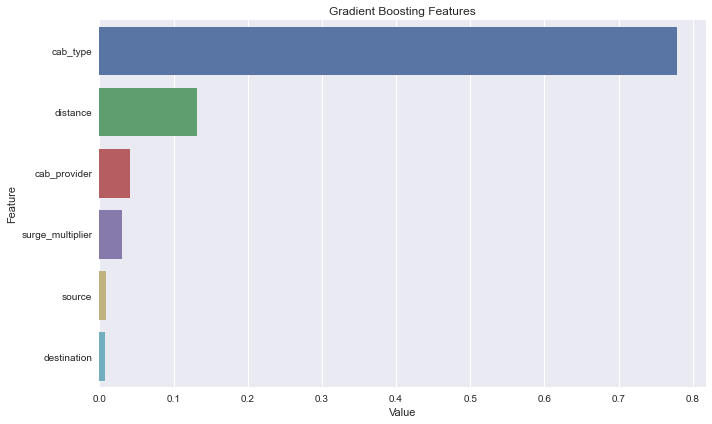

In [54]:
feature_imp = pd.DataFrame(sorted(zip(gbr.feature_importances_, X.columns), reverse=True)[:10], 
                           columns=['Value','Feature'])
plt.figure(figsize=(10,6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Gradient Boosting Features')
plt.tight_layout()
plt.show()

#### 5. XGBoost Regressor

In [55]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor 

errxgb = []
y_pred_totxgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=1)

for train_index, test_index in fold.split(X.values):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    xgbr = XGBRegressor(objective='reg:squarederror',subsample= 0.9, scale_pos_weight=5, reg_alpha =0.001, 
                        n_estimators = 1000, min_child_weight = 3, max_depth = 12, learning_rate = 0.05, gamma = 0, 
                        colsample_bytree = 0.7,seed=27)
    xgbr.fit(X_train,y_train,verbose=2999,
        eval_set=[(X_test, y_test)],early_stopping_rounds=200)
    y_pred = xgbr.predict(X_test)

    print('RMSE', rmse(np.expm1(y_test), np.expm1(y_pred)))

    errxgb.append(rmse(np.expm1(y_test), np.expm1(y_pred)))
    
print("RMSE of XGBoost regressor is: ", np.mean(errxgb,0))

[0]	validation_0-rmse:2.18079
Will train until validation_0-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[299]	validation_0-rmse:0.10567

RMSE 1.5964690698900432
[0]	validation_0-rmse:2.18296
Will train until validation_0-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[198]	validation_0-rmse:0.10972

RMSE 1.743722012672556
[0]	validation_0-rmse:2.17778
Will train until validation_0-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[281]	validation_0-rmse:0.10996

RMSE 1.6107850213365735
[0]	validation_0-rmse:2.18454
Will train until validation_0-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[283]	validation_0-rmse:0.10743

RMSE 1.5738541795088945
[0]	validation_0-rmse:2.18558
Will train until validation_0-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[303]	validation_0-rmse:0.10917

RMSE 1.7060924061160139
[0]	validation_0-rmse:2.18159
Will train until validation_0-rmse hasn't improved in 200 rounds.
Stopping. 

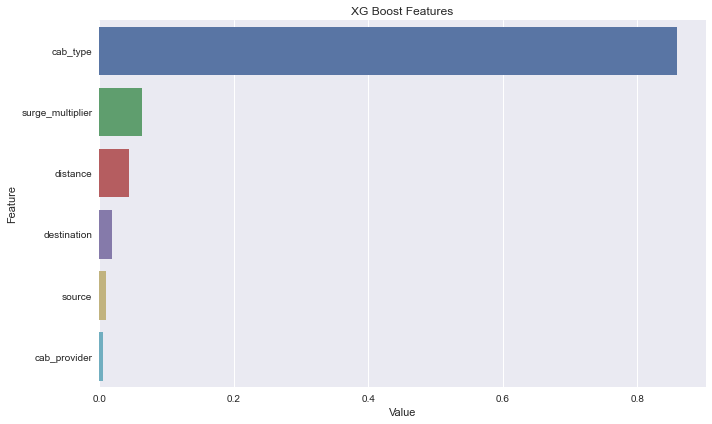

In [56]:
feature_imp = pd.DataFrame(sorted(zip(xgbr.feature_importances_, X.columns), reverse=True)[:30], 
                           columns=['Value','Feature'])
plt.figure(figsize=(10,6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XG Boost Features')
plt.tight_layout()
plt.show()

In [57]:
pkl_filename = "xgbr.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgbr, file)

#### 6. CatBoost Regressor

In [58]:
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor

errcatb = []
y_pred_totcatb = []

fold = KFold(n_splits=10, shuffle=True, random_state=1)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
             
    catb = CatBoostRegressor(subsample = 0.9, max_depth = 11, learning_rate = 0.2, l2_leaf_reg = 4, iterations= 1000,
                             bagging_temperature = 0.5)
    
    catb.fit(X_train,y_train,verbose=2999,
        eval_set=(X_test, y_test),early_stopping_rounds=200)
    y_pred = catb.predict(X_test)

    print('RMSE', rmse(np.expm1(y_test), np.expm1(y_pred)))

    errcatb.append(rmse(np.expm1(y_test), np.expm1(y_pred)))
    
print("RMSE of catboost regressor model is: ",np.mean(errcatb,0))

0:	learn: 0.4339855	test: 0.4331296	best: 0.4331296 (0)	total: 238ms	remaining: 3m 57s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.1056279827
bestIteration = 277

Shrink model to first 278 iterations.
RMSE 1.6019697429226356
0:	learn: 0.4340828	test: 0.4317672	best: 0.4317672 (0)	total: 55.3ms	remaining: 55.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.1094769681
bestIteration = 389

Shrink model to first 390 iterations.
RMSE 1.7412477590305477
0:	learn: 0.4337144	test: 0.4353610	best: 0.4353610 (0)	total: 51.2ms	remaining: 51.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.1099073941
bestIteration = 491

Shrink model to first 492 iterations.
RMSE 1.611024143066896
0:	learn: 0.4337514	test: 0.4355087	best: 0.4355087 (0)	total: 53.9ms	remaining: 53.8s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.1077282336
bestIteration = 526

Shrink model to first 527 iterations.
RMSE 1.5767299282836793
0

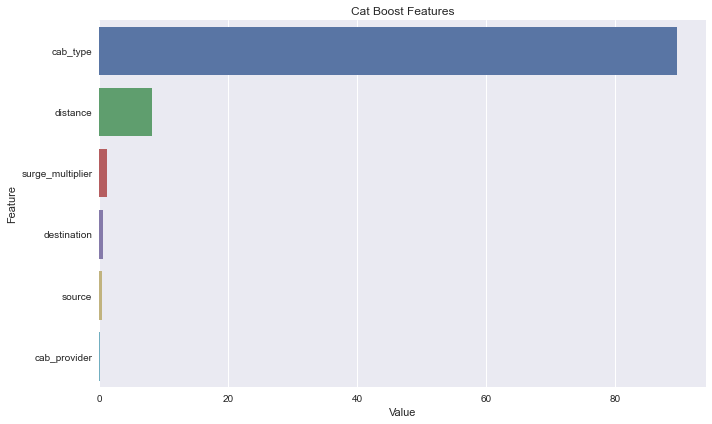

In [59]:
feature_imp = pd.DataFrame(sorted(zip(catb.feature_importances_, X.columns), reverse=True)[:30], 
                           columns=['Value','Feature'])
plt.figure(figsize=(10,6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Cat Boost Features')
plt.tight_layout()
plt.show()

#### 7. LightGBM Regressor

In [60]:
# After Hyperparametertuning best params for LGBMRegressor
param = {
         'objective': 'regression',
         'metric': 'l2_root',
         'subsample_freq': 3,
         'subsample': 0.9,
         'num_leaves': 60,
         'num_iterations': 1000,
         'min_child_samples': 10,
         'max_depth': 19,
         'max_bin': 1000,
         'learning_rate': 0.05,
         'feature_fraction_seed': 2,
         'colsample_bytree': 0.9,
         'bagging_seed': 2
        }

In [61]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    lgbm = LGBMRegressor(**param)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=-1, early_stopping_rounds=100)

    y_pred_lgbm = lgbm.predict(X_test)
    
    print("RMSE LGBM: ", rmse(np.expm1(y_test), np.expm1(y_pred_lgbm)))

    errlgb.append(rmse(np.expm1(y_test), np.expm1(y_pred_lgbm)))

print("RMSE of LGBM regressor is: ", np.mean(errlgb,0))

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[663]	valid_0's rmse: 0.110269
RMSE LGBM:  1.7457240504296898
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[910]	valid_0's rmse: 0.108999
RMSE LGBM:  1.6551992121424361
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[671]	valid_0's rmse: 0.106106
RMSE LGBM:  1.5671363702782366
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[827]	valid_0's rmse: 0.108319
RMSE LGBM:  1.6180566137969994
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[879]	valid_0's rmse: 0.107329
RMSE LGBM:  1.678916530935982
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 0.104015
RMSE LGBM:  1.6206823204439393
Training until valida

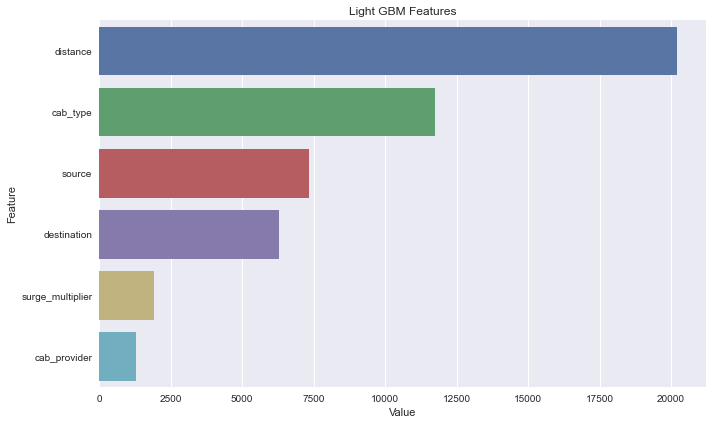

In [62]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, X.columns), reverse=True)[:30], 
                           columns=['Value','Feature'])
plt.figure(figsize=(10,6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Light GBM Features')
plt.tight_layout()
plt.show()

In [63]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import KFold, cross_val_score
kfolds = KFold(n_splits=5,shuffle=True, random_state=42)

def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X, Y_train, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [65]:
X_train,X_val, Y_train, Y_val = train_test_split(X.values,Y.values,test_size=0.25, random_state=42)
stackr = StackingCVRegressor(regressors=(catb,lgbm,gbr),meta_regressor=lgbm)
print('stacked_reggression')
stackr.fit(X_train,Y_train)
print('Score of model on validation data is: ',stackr.score(X_val,Y_val))
train_predict = stackr.predict(X_val)
rmscore = rmse(np.expm1(Y_val),np.expm1(train_predict))
print('RMSE is: ',rmscore)

stacked_reggression
0:	learn: 0.4343015	total: 43.8ms	remaining: 43.8s
1:	learn: 0.3591281	total: 85.7ms	remaining: 42.8s
2:	learn: 0.3019350	total: 128ms	remaining: 42.6s
3:	learn: 0.2556131	total: 170ms	remaining: 42.5s
4:	learn: 0.2226643	total: 213ms	remaining: 42.4s
5:	learn: 0.1960811	total: 258ms	remaining: 42.7s
6:	learn: 0.1789063	total: 301ms	remaining: 42.7s
7:	learn: 0.1625372	total: 343ms	remaining: 42.5s
8:	learn: 0.1497091	total: 385ms	remaining: 42.4s
9:	learn: 0.1413520	total: 427ms	remaining: 42.3s
10:	learn: 0.1351134	total: 472ms	remaining: 42.4s
11:	learn: 0.1308446	total: 520ms	remaining: 42.8s
12:	learn: 0.1273076	total: 568ms	remaining: 43.1s
13:	learn: 0.1248676	total: 616ms	remaining: 43.4s
14:	learn: 0.1227235	total: 659ms	remaining: 43.3s
15:	learn: 0.1212248	total: 703ms	remaining: 43.3s
16:	learn: 0.1200600	total: 750ms	remaining: 43.3s
17:	learn: 0.1190313	total: 793ms	remaining: 43.3s
18:	learn: 0.1180787	total: 836ms	remaining: 43.1s
19:	learn: 0.117457

161:	learn: 0.1060779	total: 7.28s	remaining: 37.7s
162:	learn: 0.1060405	total: 7.33s	remaining: 37.6s
163:	learn: 0.1060157	total: 7.37s	remaining: 37.6s
164:	learn: 0.1059825	total: 7.41s	remaining: 37.5s
165:	learn: 0.1059530	total: 7.45s	remaining: 37.4s
166:	learn: 0.1059294	total: 7.5s	remaining: 37.4s
167:	learn: 0.1059100	total: 7.54s	remaining: 37.4s
168:	learn: 0.1058712	total: 7.58s	remaining: 37.3s
169:	learn: 0.1058361	total: 7.63s	remaining: 37.2s
170:	learn: 0.1058092	total: 7.78s	remaining: 37.7s
171:	learn: 0.1057939	total: 7.82s	remaining: 37.6s
172:	learn: 0.1057765	total: 7.86s	remaining: 37.6s
173:	learn: 0.1057602	total: 7.9s	remaining: 37.5s
174:	learn: 0.1057405	total: 7.95s	remaining: 37.5s
175:	learn: 0.1057214	total: 7.99s	remaining: 37.4s
176:	learn: 0.1056883	total: 8.03s	remaining: 37.4s
177:	learn: 0.1056718	total: 8.07s	remaining: 37.3s
178:	learn: 0.1056412	total: 8.12s	remaining: 37.2s
179:	learn: 0.1056198	total: 8.16s	remaining: 37.2s
180:	learn: 0.

320:	learn: 0.1031069	total: 14.3s	remaining: 30.3s
321:	learn: 0.1030991	total: 14.4s	remaining: 30.3s
322:	learn: 0.1030826	total: 14.4s	remaining: 30.2s
323:	learn: 0.1030745	total: 14.5s	remaining: 30.2s
324:	learn: 0.1030617	total: 14.5s	remaining: 30.1s
325:	learn: 0.1030510	total: 14.5s	remaining: 30.1s
326:	learn: 0.1030489	total: 14.6s	remaining: 30s
327:	learn: 0.1030436	total: 14.6s	remaining: 30s
328:	learn: 0.1030350	total: 14.7s	remaining: 29.9s
329:	learn: 0.1030199	total: 14.7s	remaining: 29.9s
330:	learn: 0.1030124	total: 14.8s	remaining: 29.8s
331:	learn: 0.1030004	total: 14.8s	remaining: 29.8s
332:	learn: 0.1029868	total: 14.8s	remaining: 29.7s
333:	learn: 0.1029735	total: 14.9s	remaining: 29.7s
334:	learn: 0.1029674	total: 14.9s	remaining: 29.6s
335:	learn: 0.1029512	total: 15s	remaining: 29.6s
336:	learn: 0.1029411	total: 15s	remaining: 29.6s
337:	learn: 0.1029231	total: 15.1s	remaining: 29.5s
338:	learn: 0.1029126	total: 15.1s	remaining: 29.5s
339:	learn: 0.102899

481:	learn: 0.1015757	total: 21.7s	remaining: 23.3s
482:	learn: 0.1015675	total: 21.7s	remaining: 23.2s
483:	learn: 0.1015525	total: 21.7s	remaining: 23.2s
484:	learn: 0.1015434	total: 21.8s	remaining: 23.1s
485:	learn: 0.1015367	total: 21.8s	remaining: 23.1s
486:	learn: 0.1015314	total: 21.9s	remaining: 23s
487:	learn: 0.1015244	total: 21.9s	remaining: 23s
488:	learn: 0.1015176	total: 22s	remaining: 22.9s
489:	learn: 0.1015040	total: 22s	remaining: 22.9s
490:	learn: 0.1014916	total: 22s	remaining: 22.8s
491:	learn: 0.1014877	total: 22.2s	remaining: 22.9s
492:	learn: 0.1014778	total: 22.2s	remaining: 22.9s
493:	learn: 0.1014698	total: 22.3s	remaining: 22.8s
494:	learn: 0.1014670	total: 22.3s	remaining: 22.8s
495:	learn: 0.1014603	total: 22.4s	remaining: 22.7s
496:	learn: 0.1014511	total: 22.4s	remaining: 22.7s
497:	learn: 0.1014388	total: 22.4s	remaining: 22.6s
498:	learn: 0.1014321	total: 22.5s	remaining: 22.6s
499:	learn: 0.1014246	total: 22.5s	remaining: 22.5s
500:	learn: 0.1014138	

643:	learn: 0.1004974	total: 29s	remaining: 16s
644:	learn: 0.1004923	total: 29.1s	remaining: 16s
645:	learn: 0.1004889	total: 29.1s	remaining: 15.9s
646:	learn: 0.1004867	total: 29.1s	remaining: 15.9s
647:	learn: 0.1004829	total: 29.2s	remaining: 15.9s
648:	learn: 0.1004790	total: 29.2s	remaining: 15.8s
649:	learn: 0.1004758	total: 29.3s	remaining: 15.8s
650:	learn: 0.1004712	total: 29.3s	remaining: 15.7s
651:	learn: 0.1004617	total: 29.4s	remaining: 15.7s
652:	learn: 0.1004560	total: 29.4s	remaining: 15.6s
653:	learn: 0.1004538	total: 29.4s	remaining: 15.6s
654:	learn: 0.1004483	total: 29.5s	remaining: 15.5s
655:	learn: 0.1004426	total: 29.5s	remaining: 15.5s
656:	learn: 0.1004294	total: 29.6s	remaining: 15.4s
657:	learn: 0.1004279	total: 29.6s	remaining: 15.4s
658:	learn: 0.1004259	total: 29.7s	remaining: 15.4s
659:	learn: 0.1004195	total: 29.7s	remaining: 15.3s
660:	learn: 0.1004113	total: 29.8s	remaining: 15.3s
661:	learn: 0.1004036	total: 29.8s	remaining: 15.2s
662:	learn: 0.1003

803:	learn: 0.0997542	total: 36.2s	remaining: 8.82s
804:	learn: 0.0997526	total: 36.2s	remaining: 8.78s
805:	learn: 0.0997480	total: 36.3s	remaining: 8.73s
806:	learn: 0.0997419	total: 36.3s	remaining: 8.68s
807:	learn: 0.0997373	total: 36.4s	remaining: 8.64s
808:	learn: 0.0997274	total: 36.4s	remaining: 8.59s
809:	learn: 0.0997222	total: 36.5s	remaining: 8.57s
810:	learn: 0.0997194	total: 36.6s	remaining: 8.53s
811:	learn: 0.0997187	total: 36.6s	remaining: 8.48s
812:	learn: 0.0997163	total: 36.7s	remaining: 8.43s
813:	learn: 0.0997120	total: 36.7s	remaining: 8.39s
814:	learn: 0.0997075	total: 36.8s	remaining: 8.34s
815:	learn: 0.0997035	total: 36.8s	remaining: 8.3s
816:	learn: 0.0997002	total: 36.8s	remaining: 8.25s
817:	learn: 0.0996942	total: 36.9s	remaining: 8.21s
818:	learn: 0.0996914	total: 36.9s	remaining: 8.16s
819:	learn: 0.0996862	total: 37s	remaining: 8.11s
820:	learn: 0.0996825	total: 37s	remaining: 8.07s
821:	learn: 0.0996796	total: 37s	remaining: 8.02s
822:	learn: 0.09967

962:	learn: 0.0991984	total: 43.7s	remaining: 1.68s
963:	learn: 0.0991924	total: 43.8s	remaining: 1.63s
964:	learn: 0.0991895	total: 43.8s	remaining: 1.59s
965:	learn: 0.0991870	total: 43.8s	remaining: 1.54s
966:	learn: 0.0991853	total: 43.9s	remaining: 1.5s
967:	learn: 0.0991811	total: 43.9s	remaining: 1.45s
968:	learn: 0.0991793	total: 44s	remaining: 1.41s
969:	learn: 0.0991763	total: 44s	remaining: 1.36s
970:	learn: 0.0991742	total: 44.1s	remaining: 1.31s
971:	learn: 0.0991733	total: 44.1s	remaining: 1.27s
972:	learn: 0.0991723	total: 44.1s	remaining: 1.22s
973:	learn: 0.0991709	total: 44.2s	remaining: 1.18s
974:	learn: 0.0991656	total: 44.2s	remaining: 1.13s
975:	learn: 0.0991623	total: 44.3s	remaining: 1.09s
976:	learn: 0.0991536	total: 44.3s	remaining: 1.04s
977:	learn: 0.0991533	total: 44.4s	remaining: 998ms
978:	learn: 0.0991515	total: 44.4s	remaining: 952ms
979:	learn: 0.0991459	total: 44.4s	remaining: 907ms
980:	learn: 0.0991397	total: 44.5s	remaining: 862ms
981:	learn: 0.099

126:	learn: 0.1063306	total: 5.69s	remaining: 39.1s
127:	learn: 0.1063089	total: 5.73s	remaining: 39s
128:	learn: 0.1062842	total: 5.77s	remaining: 39s
129:	learn: 0.1062597	total: 5.81s	remaining: 38.9s
130:	learn: 0.1062262	total: 5.86s	remaining: 38.8s
131:	learn: 0.1061985	total: 5.9s	remaining: 38.8s
132:	learn: 0.1061639	total: 5.95s	remaining: 38.8s
133:	learn: 0.1061315	total: 5.99s	remaining: 38.7s
134:	learn: 0.1061085	total: 6.03s	remaining: 38.6s
135:	learn: 0.1060760	total: 6.07s	remaining: 38.6s
136:	learn: 0.1060492	total: 6.12s	remaining: 38.5s
137:	learn: 0.1060090	total: 6.16s	remaining: 38.5s
138:	learn: 0.1059965	total: 6.2s	remaining: 38.4s
139:	learn: 0.1059744	total: 6.24s	remaining: 38.4s
140:	learn: 0.1059581	total: 6.29s	remaining: 38.3s
141:	learn: 0.1059394	total: 6.33s	remaining: 38.3s
142:	learn: 0.1059213	total: 6.37s	remaining: 38.2s
143:	learn: 0.1058847	total: 6.42s	remaining: 38.1s
144:	learn: 0.1058515	total: 6.46s	remaining: 38.1s
145:	learn: 0.1058

288:	learn: 0.1028468	total: 12.9s	remaining: 31.7s
289:	learn: 0.1028400	total: 12.9s	remaining: 31.7s
290:	learn: 0.1028230	total: 13s	remaining: 31.6s
291:	learn: 0.1028134	total: 13s	remaining: 31.6s
292:	learn: 0.1028066	total: 13.1s	remaining: 31.5s
293:	learn: 0.1027817	total: 13.1s	remaining: 31.5s
294:	learn: 0.1027689	total: 13.1s	remaining: 31.4s
295:	learn: 0.1027584	total: 13.2s	remaining: 31.4s
296:	learn: 0.1027378	total: 13.2s	remaining: 31.3s
297:	learn: 0.1027258	total: 13.3s	remaining: 31.3s
298:	learn: 0.1027180	total: 13.3s	remaining: 31.2s
299:	learn: 0.1027114	total: 13.4s	remaining: 31.2s
300:	learn: 0.1027025	total: 13.4s	remaining: 31.1s
301:	learn: 0.1026887	total: 13.4s	remaining: 31.1s
302:	learn: 0.1026743	total: 13.5s	remaining: 31s
303:	learn: 0.1026558	total: 13.5s	remaining: 31s
304:	learn: 0.1026483	total: 13.6s	remaining: 30.9s
305:	learn: 0.1026429	total: 13.6s	remaining: 30.9s
306:	learn: 0.1026305	total: 13.7s	remaining: 30.8s
307:	learn: 0.102620

450:	learn: 0.1010767	total: 20.1s	remaining: 24.5s
451:	learn: 0.1010652	total: 20.1s	remaining: 24.4s
452:	learn: 0.1010581	total: 20.2s	remaining: 24.4s
453:	learn: 0.1010508	total: 20.2s	remaining: 24.3s
454:	learn: 0.1010458	total: 20.3s	remaining: 24.3s
455:	learn: 0.1010342	total: 20.3s	remaining: 24.2s
456:	learn: 0.1010298	total: 20.4s	remaining: 24.2s
457:	learn: 0.1010098	total: 20.4s	remaining: 24.1s
458:	learn: 0.1010006	total: 20.4s	remaining: 24.1s
459:	learn: 0.1009941	total: 20.5s	remaining: 24s
460:	learn: 0.1009915	total: 20.5s	remaining: 24s
461:	learn: 0.1009886	total: 20.6s	remaining: 24s
462:	learn: 0.1009793	total: 20.6s	remaining: 23.9s
463:	learn: 0.1009735	total: 20.7s	remaining: 23.9s
464:	learn: 0.1009558	total: 20.7s	remaining: 23.8s
465:	learn: 0.1009443	total: 20.7s	remaining: 23.8s
466:	learn: 0.1009326	total: 20.8s	remaining: 23.7s
467:	learn: 0.1009295	total: 20.8s	remaining: 23.7s
468:	learn: 0.1009208	total: 20.9s	remaining: 23.6s
469:	learn: 0.1009

611:	learn: 0.0999274	total: 27.2s	remaining: 17.3s
612:	learn: 0.0999226	total: 27.3s	remaining: 17.2s
613:	learn: 0.0999122	total: 27.3s	remaining: 17.2s
614:	learn: 0.0999059	total: 27.4s	remaining: 17.1s
615:	learn: 0.0998935	total: 27.4s	remaining: 17.1s
616:	learn: 0.0998811	total: 27.5s	remaining: 17s
617:	learn: 0.0998752	total: 27.5s	remaining: 17s
618:	learn: 0.0998680	total: 27.5s	remaining: 17s
619:	learn: 0.0998629	total: 27.6s	remaining: 16.9s
620:	learn: 0.0998613	total: 27.6s	remaining: 16.9s
621:	learn: 0.0998568	total: 27.7s	remaining: 16.8s
622:	learn: 0.0998512	total: 27.7s	remaining: 16.8s
623:	learn: 0.0998440	total: 27.8s	remaining: 16.7s
624:	learn: 0.0998358	total: 27.8s	remaining: 16.7s
625:	learn: 0.0998288	total: 27.8s	remaining: 16.6s
626:	learn: 0.0998246	total: 27.9s	remaining: 16.6s
627:	learn: 0.0998187	total: 27.9s	remaining: 16.5s
628:	learn: 0.0998124	total: 28s	remaining: 16.5s
629:	learn: 0.0998061	total: 28s	remaining: 16.4s
630:	learn: 0.0998023	

774:	learn: 0.0991471	total: 34.3s	remaining: 9.95s
775:	learn: 0.0991449	total: 34.3s	remaining: 9.91s
776:	learn: 0.0991410	total: 34.4s	remaining: 9.86s
777:	learn: 0.0991344	total: 34.4s	remaining: 9.82s
778:	learn: 0.0991250	total: 34.5s	remaining: 9.78s
779:	learn: 0.0991134	total: 34.5s	remaining: 9.73s
780:	learn: 0.0991108	total: 34.6s	remaining: 9.69s
781:	learn: 0.0991091	total: 34.6s	remaining: 9.64s
782:	learn: 0.0991051	total: 34.6s	remaining: 9.6s
783:	learn: 0.0991009	total: 34.7s	remaining: 9.55s
784:	learn: 0.0990974	total: 34.7s	remaining: 9.51s
785:	learn: 0.0990945	total: 34.8s	remaining: 9.46s
786:	learn: 0.0990871	total: 34.8s	remaining: 9.42s
787:	learn: 0.0990822	total: 34.9s	remaining: 9.38s
788:	learn: 0.0990792	total: 34.9s	remaining: 9.33s
789:	learn: 0.0990726	total: 34.9s	remaining: 9.29s
790:	learn: 0.0990706	total: 35s	remaining: 9.24s
791:	learn: 0.0990684	total: 35s	remaining: 9.2s
792:	learn: 0.0990642	total: 35.1s	remaining: 9.15s
793:	learn: 0.0990

936:	learn: 0.0985400	total: 41.6s	remaining: 2.8s
937:	learn: 0.0985376	total: 41.7s	remaining: 2.75s
938:	learn: 0.0985337	total: 41.7s	remaining: 2.71s
939:	learn: 0.0985322	total: 41.8s	remaining: 2.67s
940:	learn: 0.0985284	total: 41.8s	remaining: 2.62s
941:	learn: 0.0985264	total: 41.8s	remaining: 2.58s
942:	learn: 0.0985229	total: 41.9s	remaining: 2.53s
943:	learn: 0.0985199	total: 41.9s	remaining: 2.49s
944:	learn: 0.0985183	total: 42s	remaining: 2.44s
945:	learn: 0.0985132	total: 42s	remaining: 2.4s
946:	learn: 0.0985096	total: 42s	remaining: 2.35s
947:	learn: 0.0985079	total: 42.1s	remaining: 2.31s
948:	learn: 0.0985063	total: 42.1s	remaining: 2.26s
949:	learn: 0.0985040	total: 42.2s	remaining: 2.22s
950:	learn: 0.0985012	total: 42.2s	remaining: 2.17s
951:	learn: 0.0984961	total: 42.3s	remaining: 2.13s
952:	learn: 0.0984895	total: 42.3s	remaining: 2.09s
953:	learn: 0.0984878	total: 42.3s	remaining: 2.04s
954:	learn: 0.0984868	total: 42.4s	remaining: 2s
955:	learn: 0.0984836	t

99:	learn: 0.1083835	total: 4.42s	remaining: 39.8s
100:	learn: 0.1083245	total: 4.46s	remaining: 39.7s
101:	learn: 0.1083007	total: 4.5s	remaining: 39.6s
102:	learn: 0.1082339	total: 4.54s	remaining: 39.6s
103:	learn: 0.1081755	total: 4.59s	remaining: 39.5s
104:	learn: 0.1081310	total: 4.63s	remaining: 39.5s
105:	learn: 0.1080869	total: 4.67s	remaining: 39.4s
106:	learn: 0.1080254	total: 4.72s	remaining: 39.4s
107:	learn: 0.1079918	total: 4.76s	remaining: 39.3s
108:	learn: 0.1079658	total: 4.8s	remaining: 39.3s
109:	learn: 0.1079127	total: 4.85s	remaining: 39.2s
110:	learn: 0.1078774	total: 4.89s	remaining: 39.2s
111:	learn: 0.1078385	total: 4.93s	remaining: 39.1s
112:	learn: 0.1078031	total: 4.97s	remaining: 39s
113:	learn: 0.1077478	total: 5.01s	remaining: 39s
114:	learn: 0.1076672	total: 5.06s	remaining: 38.9s
115:	learn: 0.1076089	total: 5.1s	remaining: 38.9s
116:	learn: 0.1075532	total: 5.14s	remaining: 38.8s
117:	learn: 0.1075288	total: 5.19s	remaining: 38.8s
118:	learn: 0.107488

262:	learn: 0.1040223	total: 11.9s	remaining: 33.2s
263:	learn: 0.1040041	total: 11.9s	remaining: 33.2s
264:	learn: 0.1039943	total: 11.9s	remaining: 33.1s
265:	learn: 0.1039851	total: 12s	remaining: 33.1s
266:	learn: 0.1039727	total: 12s	remaining: 33s
267:	learn: 0.1039518	total: 12.1s	remaining: 33s
268:	learn: 0.1039289	total: 12.1s	remaining: 32.9s
269:	learn: 0.1039150	total: 12.2s	remaining: 32.9s
270:	learn: 0.1038922	total: 12.2s	remaining: 32.8s
271:	learn: 0.1038847	total: 12.3s	remaining: 32.8s
272:	learn: 0.1038658	total: 12.3s	remaining: 32.7s
273:	learn: 0.1038532	total: 12.3s	remaining: 32.7s
274:	learn: 0.1038274	total: 12.4s	remaining: 32.6s
275:	learn: 0.1038104	total: 12.4s	remaining: 32.6s
276:	learn: 0.1037943	total: 12.5s	remaining: 32.5s
277:	learn: 0.1037795	total: 12.5s	remaining: 32.5s
278:	learn: 0.1037592	total: 12.6s	remaining: 32.4s
279:	learn: 0.1037441	total: 12.6s	remaining: 32.4s
280:	learn: 0.1037330	total: 12.6s	remaining: 32.3s
281:	learn: 0.103724

423:	learn: 0.1019825	total: 19.1s	remaining: 26s
424:	learn: 0.1019706	total: 19.2s	remaining: 26s
425:	learn: 0.1019578	total: 19.2s	remaining: 25.9s
426:	learn: 0.1019507	total: 19.3s	remaining: 25.9s
427:	learn: 0.1019439	total: 19.3s	remaining: 25.8s
428:	learn: 0.1019327	total: 19.4s	remaining: 25.8s
429:	learn: 0.1019253	total: 19.4s	remaining: 25.7s
430:	learn: 0.1019178	total: 19.4s	remaining: 25.7s
431:	learn: 0.1019105	total: 19.5s	remaining: 25.6s
432:	learn: 0.1019051	total: 19.5s	remaining: 25.6s
433:	learn: 0.1018916	total: 19.6s	remaining: 25.5s
434:	learn: 0.1018710	total: 19.6s	remaining: 25.5s
435:	learn: 0.1018595	total: 19.7s	remaining: 25.4s
436:	learn: 0.1018457	total: 19.7s	remaining: 25.4s
437:	learn: 0.1018377	total: 19.7s	remaining: 25.3s
438:	learn: 0.1018310	total: 19.8s	remaining: 25.3s
439:	learn: 0.1018247	total: 19.8s	remaining: 25.2s
440:	learn: 0.1018178	total: 19.9s	remaining: 25.2s
441:	learn: 0.1018117	total: 19.9s	remaining: 25.1s
442:	learn: 0.10

583:	learn: 0.1007572	total: 26.3s	remaining: 18.7s
584:	learn: 0.1007525	total: 26.4s	remaining: 18.7s
585:	learn: 0.1007486	total: 26.4s	remaining: 18.7s
586:	learn: 0.1007401	total: 26.4s	remaining: 18.6s
587:	learn: 0.1007358	total: 26.5s	remaining: 18.6s
588:	learn: 0.1007287	total: 26.5s	remaining: 18.5s
589:	learn: 0.1007150	total: 26.6s	remaining: 18.5s
590:	learn: 0.1007090	total: 26.6s	remaining: 18.4s
591:	learn: 0.1007030	total: 26.7s	remaining: 18.4s
592:	learn: 0.1006958	total: 26.7s	remaining: 18.3s
593:	learn: 0.1006923	total: 26.7s	remaining: 18.3s
594:	learn: 0.1006878	total: 26.8s	remaining: 18.2s
595:	learn: 0.1006849	total: 26.8s	remaining: 18.2s
596:	learn: 0.1006789	total: 26.9s	remaining: 18.1s
597:	learn: 0.1006728	total: 27s	remaining: 18.2s
598:	learn: 0.1006591	total: 27.1s	remaining: 18.1s
599:	learn: 0.1006565	total: 27.1s	remaining: 18.1s
600:	learn: 0.1006551	total: 27.2s	remaining: 18s
601:	learn: 0.1006446	total: 27.2s	remaining: 18s
602:	learn: 0.1006

744:	learn: 0.0998767	total: 33.8s	remaining: 11.6s
745:	learn: 0.0998759	total: 33.8s	remaining: 11.5s
746:	learn: 0.0998719	total: 33.9s	remaining: 11.5s
747:	learn: 0.0998681	total: 33.9s	remaining: 11.4s
748:	learn: 0.0998656	total: 34s	remaining: 11.4s
749:	learn: 0.0998611	total: 34s	remaining: 11.3s
750:	learn: 0.0998549	total: 34s	remaining: 11.3s
751:	learn: 0.0998496	total: 34.2s	remaining: 11.3s
752:	learn: 0.0998472	total: 34.2s	remaining: 11.2s
753:	learn: 0.0998434	total: 34.3s	remaining: 11.2s
754:	learn: 0.0998397	total: 34.3s	remaining: 11.1s
755:	learn: 0.0998358	total: 34.4s	remaining: 11.1s
756:	learn: 0.0998312	total: 34.4s	remaining: 11s
757:	learn: 0.0998271	total: 34.5s	remaining: 11s
758:	learn: 0.0998252	total: 34.5s	remaining: 11s
759:	learn: 0.0998198	total: 34.5s	remaining: 10.9s
760:	learn: 0.0998145	total: 34.6s	remaining: 10.9s
761:	learn: 0.0998110	total: 34.6s	remaining: 10.8s
762:	learn: 0.0998043	total: 34.7s	remaining: 10.8s
763:	learn: 0.0998002	to

904:	learn: 0.0992484	total: 41.1s	remaining: 4.32s
905:	learn: 0.0992472	total: 41.2s	remaining: 4.27s
906:	learn: 0.0992461	total: 41.2s	remaining: 4.22s
907:	learn: 0.0992438	total: 41.3s	remaining: 4.18s
908:	learn: 0.0992427	total: 41.3s	remaining: 4.13s
909:	learn: 0.0992417	total: 41.4s	remaining: 4.09s
910:	learn: 0.0992387	total: 41.4s	remaining: 4.04s
911:	learn: 0.0992333	total: 41.4s	remaining: 4s
912:	learn: 0.0992298	total: 41.5s	remaining: 3.95s
913:	learn: 0.0992266	total: 41.5s	remaining: 3.91s
914:	learn: 0.0992250	total: 41.6s	remaining: 3.86s
915:	learn: 0.0992227	total: 41.6s	remaining: 3.81s
916:	learn: 0.0992207	total: 41.6s	remaining: 3.77s
917:	learn: 0.0992201	total: 41.7s	remaining: 3.72s
918:	learn: 0.0992188	total: 41.7s	remaining: 3.67s
919:	learn: 0.0992154	total: 41.7s	remaining: 3.63s
920:	learn: 0.0992131	total: 41.8s	remaining: 3.58s
921:	learn: 0.0992092	total: 41.8s	remaining: 3.54s
922:	learn: 0.0992068	total: 41.9s	remaining: 3.49s
923:	learn: 0.0

67:	learn: 0.1091961	total: 3.2s	remaining: 43.9s
68:	learn: 0.1091321	total: 3.25s	remaining: 43.8s
69:	learn: 0.1090692	total: 3.3s	remaining: 43.8s
70:	learn: 0.1089712	total: 3.35s	remaining: 43.9s
71:	learn: 0.1089265	total: 3.41s	remaining: 43.9s
72:	learn: 0.1088324	total: 3.56s	remaining: 45.2s
73:	learn: 0.1087770	total: 3.61s	remaining: 45.1s
74:	learn: 0.1086960	total: 3.67s	remaining: 45.3s
75:	learn: 0.1086346	total: 3.73s	remaining: 45.3s
76:	learn: 0.1085953	total: 3.78s	remaining: 45.4s
77:	learn: 0.1085535	total: 3.86s	remaining: 45.7s
78:	learn: 0.1084936	total: 3.91s	remaining: 45.6s
79:	learn: 0.1084482	total: 3.96s	remaining: 45.5s
80:	learn: 0.1083670	total: 4s	remaining: 45.4s
81:	learn: 0.1083235	total: 4.05s	remaining: 45.3s
82:	learn: 0.1082927	total: 4.09s	remaining: 45.2s
83:	learn: 0.1082086	total: 4.14s	remaining: 45.1s
84:	learn: 0.1081707	total: 4.19s	remaining: 45.1s
85:	learn: 0.1081203	total: 4.25s	remaining: 45.2s
86:	learn: 0.1080901	total: 4.31s	re

228:	learn: 0.1038927	total: 11.4s	remaining: 38.5s
229:	learn: 0.1038805	total: 11.5s	remaining: 38.4s
230:	learn: 0.1038525	total: 11.5s	remaining: 38.3s
231:	learn: 0.1038274	total: 11.6s	remaining: 38.3s
232:	learn: 0.1038127	total: 11.6s	remaining: 38.2s
233:	learn: 0.1037935	total: 11.6s	remaining: 38.1s
234:	learn: 0.1037733	total: 11.7s	remaining: 38s
235:	learn: 0.1037610	total: 11.7s	remaining: 38s
236:	learn: 0.1037382	total: 11.8s	remaining: 37.9s
237:	learn: 0.1037142	total: 11.8s	remaining: 37.8s
238:	learn: 0.1036987	total: 12s	remaining: 38.1s
239:	learn: 0.1036820	total: 12s	remaining: 38s
240:	learn: 0.1036673	total: 12.1s	remaining: 38s
241:	learn: 0.1036510	total: 12.1s	remaining: 37.9s
242:	learn: 0.1036322	total: 12.1s	remaining: 37.8s
243:	learn: 0.1036090	total: 12.2s	remaining: 37.7s
244:	learn: 0.1035987	total: 12.2s	remaining: 37.7s
245:	learn: 0.1035762	total: 12.3s	remaining: 37.6s
246:	learn: 0.1035611	total: 12.3s	remaining: 37.5s
247:	learn: 0.1035453	to

390:	learn: 0.1017039	total: 19s	remaining: 29.6s
391:	learn: 0.1016974	total: 19.1s	remaining: 29.6s
392:	learn: 0.1016862	total: 19.1s	remaining: 29.5s
393:	learn: 0.1016773	total: 19.1s	remaining: 29.4s
394:	learn: 0.1016703	total: 19.2s	remaining: 29.4s
395:	learn: 0.1016538	total: 19.2s	remaining: 29.3s
396:	learn: 0.1016423	total: 19.3s	remaining: 29.3s
397:	learn: 0.1016339	total: 19.3s	remaining: 29.2s
398:	learn: 0.1016144	total: 19.4s	remaining: 29.2s
399:	learn: 0.1016107	total: 19.4s	remaining: 29.1s
400:	learn: 0.1015877	total: 19.4s	remaining: 29s
401:	learn: 0.1015650	total: 19.5s	remaining: 29s
402:	learn: 0.1015488	total: 19.5s	remaining: 28.9s
403:	learn: 0.1015433	total: 19.6s	remaining: 28.9s
404:	learn: 0.1015348	total: 19.6s	remaining: 28.8s
405:	learn: 0.1015189	total: 19.7s	remaining: 28.8s
406:	learn: 0.1015065	total: 19.7s	remaining: 28.7s
407:	learn: 0.1014918	total: 19.7s	remaining: 28.6s
408:	learn: 0.1014824	total: 19.8s	remaining: 28.6s
409:	learn: 0.1014

551:	learn: 0.1003372	total: 26.9s	remaining: 21.8s
552:	learn: 0.1003320	total: 26.9s	remaining: 21.8s
553:	learn: 0.1003262	total: 27s	remaining: 21.7s
554:	learn: 0.1003164	total: 27s	remaining: 21.7s
555:	learn: 0.1003048	total: 27.1s	remaining: 21.6s
556:	learn: 0.1002941	total: 27.1s	remaining: 21.6s
557:	learn: 0.1002913	total: 27.2s	remaining: 21.5s
558:	learn: 0.1002766	total: 27.2s	remaining: 21.5s
559:	learn: 0.1002730	total: 27.4s	remaining: 21.5s
560:	learn: 0.1002700	total: 27.4s	remaining: 21.5s
561:	learn: 0.1002637	total: 27.5s	remaining: 21.4s
562:	learn: 0.1002567	total: 27.5s	remaining: 21.4s
563:	learn: 0.1002545	total: 27.6s	remaining: 21.3s
564:	learn: 0.1002483	total: 27.6s	remaining: 21.2s
565:	learn: 0.1002449	total: 27.6s	remaining: 21.2s
566:	learn: 0.1002407	total: 27.7s	remaining: 21.1s
567:	learn: 0.1002306	total: 27.7s	remaining: 21.1s
568:	learn: 0.1002262	total: 27.8s	remaining: 21s
569:	learn: 0.1002171	total: 27.8s	remaining: 21s
570:	learn: 0.100206

714:	learn: 0.0994477	total: 34.8s	remaining: 13.9s
715:	learn: 0.0994447	total: 34.8s	remaining: 13.8s
716:	learn: 0.0994412	total: 34.9s	remaining: 13.8s
717:	learn: 0.0994339	total: 34.9s	remaining: 13.7s
718:	learn: 0.0994297	total: 35s	remaining: 13.7s
719:	learn: 0.0994231	total: 35s	remaining: 13.6s
720:	learn: 0.0994171	total: 35s	remaining: 13.6s
721:	learn: 0.0994141	total: 35.1s	remaining: 13.5s
722:	learn: 0.0994107	total: 35.1s	remaining: 13.5s
723:	learn: 0.0994039	total: 35.2s	remaining: 13.4s
724:	learn: 0.0993991	total: 35.2s	remaining: 13.4s
725:	learn: 0.0993909	total: 35.3s	remaining: 13.3s
726:	learn: 0.0993882	total: 35.3s	remaining: 13.3s
727:	learn: 0.0993807	total: 35.4s	remaining: 13.2s
728:	learn: 0.0993767	total: 35.4s	remaining: 13.2s
729:	learn: 0.0993712	total: 35.5s	remaining: 13.1s
730:	learn: 0.0993678	total: 35.5s	remaining: 13.1s
731:	learn: 0.0993628	total: 35.6s	remaining: 13s
732:	learn: 0.0993612	total: 35.6s	remaining: 13s
733:	learn: 0.0993546	

875:	learn: 0.0987791	total: 42.2s	remaining: 5.97s
876:	learn: 0.0987740	total: 42.3s	remaining: 5.92s
877:	learn: 0.0987699	total: 42.3s	remaining: 5.88s
878:	learn: 0.0987690	total: 42.3s	remaining: 5.83s
879:	learn: 0.0987617	total: 42.4s	remaining: 5.78s
880:	learn: 0.0987582	total: 42.4s	remaining: 5.73s
881:	learn: 0.0987541	total: 42.5s	remaining: 5.68s
882:	learn: 0.0987470	total: 42.5s	remaining: 5.63s
883:	learn: 0.0987436	total: 42.6s	remaining: 5.58s
884:	learn: 0.0987396	total: 42.6s	remaining: 5.54s
885:	learn: 0.0987387	total: 42.7s	remaining: 5.49s
886:	learn: 0.0987353	total: 42.7s	remaining: 5.44s
887:	learn: 0.0987302	total: 42.7s	remaining: 5.39s
888:	learn: 0.0987272	total: 42.8s	remaining: 5.34s
889:	learn: 0.0987244	total: 42.8s	remaining: 5.29s
890:	learn: 0.0987236	total: 42.9s	remaining: 5.25s
891:	learn: 0.0987168	total: 42.9s	remaining: 5.2s
892:	learn: 0.0987149	total: 43s	remaining: 5.15s
893:	learn: 0.0987098	total: 43s	remaining: 5.1s
894:	learn: 0.0987

38:	learn: 0.1121560	total: 1.76s	remaining: 43.4s
39:	learn: 0.1120823	total: 1.81s	remaining: 43.4s
40:	learn: 0.1119197	total: 1.85s	remaining: 43.3s
41:	learn: 0.1118303	total: 1.9s	remaining: 43.2s
42:	learn: 0.1116226	total: 1.94s	remaining: 43.2s
43:	learn: 0.1115375	total: 1.99s	remaining: 43.2s
44:	learn: 0.1114289	total: 2.04s	remaining: 43.2s
45:	learn: 0.1112825	total: 2.17s	remaining: 45.1s
46:	learn: 0.1110820	total: 2.22s	remaining: 45.1s
47:	learn: 0.1109442	total: 2.27s	remaining: 45s
48:	learn: 0.1108173	total: 2.31s	remaining: 44.8s
49:	learn: 0.1107629	total: 2.35s	remaining: 44.7s
50:	learn: 0.1107271	total: 2.4s	remaining: 44.7s
51:	learn: 0.1106658	total: 2.45s	remaining: 44.6s
52:	learn: 0.1105674	total: 2.49s	remaining: 44.5s
53:	learn: 0.1104975	total: 2.54s	remaining: 44.4s
54:	learn: 0.1104387	total: 2.58s	remaining: 44.3s
55:	learn: 0.1103192	total: 2.63s	remaining: 44.3s
56:	learn: 0.1102279	total: 2.67s	remaining: 44.2s
57:	learn: 0.1101429	total: 2.72s	r

199:	learn: 0.1045765	total: 9.41s	remaining: 37.6s
200:	learn: 0.1045495	total: 9.45s	remaining: 37.6s
201:	learn: 0.1045248	total: 9.5s	remaining: 37.5s
202:	learn: 0.1045131	total: 9.54s	remaining: 37.5s
203:	learn: 0.1044962	total: 9.59s	remaining: 37.4s
204:	learn: 0.1044670	total: 9.63s	remaining: 37.4s
205:	learn: 0.1044373	total: 9.68s	remaining: 37.3s
206:	learn: 0.1044274	total: 9.72s	remaining: 37.2s
207:	learn: 0.1043979	total: 9.77s	remaining: 37.2s
208:	learn: 0.1043613	total: 9.81s	remaining: 37.1s
209:	learn: 0.1043384	total: 9.86s	remaining: 37.1s
210:	learn: 0.1043292	total: 9.91s	remaining: 37s
211:	learn: 0.1043139	total: 9.95s	remaining: 37s
212:	learn: 0.1042879	total: 10s	remaining: 36.9s
213:	learn: 0.1042558	total: 10s	remaining: 36.9s
214:	learn: 0.1042489	total: 10.1s	remaining: 36.8s
215:	learn: 0.1042303	total: 10.1s	remaining: 36.8s
216:	learn: 0.1042031	total: 10.2s	remaining: 36.7s
217:	learn: 0.1041791	total: 10.2s	remaining: 36.7s
218:	learn: 0.1041406

360:	learn: 0.1019609	total: 17.1s	remaining: 30.3s
361:	learn: 0.1019514	total: 17.2s	remaining: 30.3s
362:	learn: 0.1019458	total: 17.2s	remaining: 30.2s
363:	learn: 0.1019366	total: 17.3s	remaining: 30.2s
364:	learn: 0.1019261	total: 17.3s	remaining: 30.1s
365:	learn: 0.1019125	total: 17.4s	remaining: 30.1s
366:	learn: 0.1019003	total: 17.4s	remaining: 30s
367:	learn: 0.1018815	total: 17.5s	remaining: 30s
368:	learn: 0.1018695	total: 17.5s	remaining: 29.9s
369:	learn: 0.1018659	total: 17.5s	remaining: 29.9s
370:	learn: 0.1018611	total: 17.6s	remaining: 29.8s
371:	learn: 0.1018508	total: 17.6s	remaining: 29.8s
372:	learn: 0.1018415	total: 17.7s	remaining: 29.7s
373:	learn: 0.1018213	total: 17.7s	remaining: 29.7s
374:	learn: 0.1018164	total: 17.8s	remaining: 29.6s
375:	learn: 0.1018059	total: 17.8s	remaining: 29.6s
376:	learn: 0.1017857	total: 17.9s	remaining: 29.5s
377:	learn: 0.1017799	total: 17.9s	remaining: 29.5s
378:	learn: 0.1017736	total: 18s	remaining: 29.4s
379:	learn: 0.1017

519:	learn: 0.1005669	total: 24.5s	remaining: 22.6s
520:	learn: 0.1005603	total: 24.5s	remaining: 22.6s
521:	learn: 0.1005536	total: 24.6s	remaining: 22.5s
522:	learn: 0.1005466	total: 24.6s	remaining: 22.5s
523:	learn: 0.1005285	total: 24.7s	remaining: 22.4s
524:	learn: 0.1005169	total: 24.8s	remaining: 22.5s
525:	learn: 0.1005141	total: 24.9s	remaining: 22.4s
526:	learn: 0.1005060	total: 24.9s	remaining: 22.4s
527:	learn: 0.1005022	total: 25s	remaining: 22.3s
528:	learn: 0.1004912	total: 25s	remaining: 22.3s
529:	learn: 0.1004876	total: 25.1s	remaining: 22.2s
530:	learn: 0.1004775	total: 25.1s	remaining: 22.2s
531:	learn: 0.1004684	total: 25.1s	remaining: 22.1s
532:	learn: 0.1004602	total: 25.2s	remaining: 22.1s
533:	learn: 0.1004569	total: 25.2s	remaining: 22s
534:	learn: 0.1004458	total: 25.3s	remaining: 22s
535:	learn: 0.1004415	total: 25.3s	remaining: 21.9s
536:	learn: 0.1004349	total: 25.4s	remaining: 21.9s
537:	learn: 0.1004205	total: 25.4s	remaining: 21.8s
538:	learn: 0.100412

680:	learn: 0.0995886	total: 32.2s	remaining: 15.1s
681:	learn: 0.0995866	total: 32.3s	remaining: 15.1s
682:	learn: 0.0995807	total: 32.3s	remaining: 15s
683:	learn: 0.0995762	total: 32.4s	remaining: 15s
684:	learn: 0.0995726	total: 32.4s	remaining: 14.9s
685:	learn: 0.0995643	total: 32.5s	remaining: 14.9s
686:	learn: 0.0995604	total: 32.5s	remaining: 14.8s
687:	learn: 0.0995515	total: 32.6s	remaining: 14.8s
688:	learn: 0.0995465	total: 32.6s	remaining: 14.7s
689:	learn: 0.0995423	total: 32.7s	remaining: 14.7s
690:	learn: 0.0995381	total: 32.7s	remaining: 14.6s
691:	learn: 0.0995334	total: 32.7s	remaining: 14.6s
692:	learn: 0.0995280	total: 32.8s	remaining: 14.5s
693:	learn: 0.0995239	total: 32.8s	remaining: 14.5s
694:	learn: 0.0995210	total: 32.9s	remaining: 14.4s
695:	learn: 0.0995181	total: 32.9s	remaining: 14.4s
696:	learn: 0.0995126	total: 33s	remaining: 14.3s
697:	learn: 0.0995072	total: 33s	remaining: 14.3s
698:	learn: 0.0995047	total: 33.2s	remaining: 14.3s
699:	learn: 0.099498

842:	learn: 0.0988993	total: 40s	remaining: 7.45s
843:	learn: 0.0988976	total: 40s	remaining: 7.4s
844:	learn: 0.0988940	total: 40.1s	remaining: 7.35s
845:	learn: 0.0988899	total: 40.1s	remaining: 7.3s
846:	learn: 0.0988879	total: 40.2s	remaining: 7.25s
847:	learn: 0.0988872	total: 40.2s	remaining: 7.21s
848:	learn: 0.0988859	total: 40.3s	remaining: 7.16s
849:	learn: 0.0988811	total: 40.3s	remaining: 7.11s
850:	learn: 0.0988792	total: 40.4s	remaining: 7.07s
851:	learn: 0.0988767	total: 40.4s	remaining: 7.02s
852:	learn: 0.0988756	total: 40.4s	remaining: 6.97s
853:	learn: 0.0988725	total: 40.5s	remaining: 6.92s
854:	learn: 0.0988701	total: 40.5s	remaining: 6.87s
855:	learn: 0.0988636	total: 40.6s	remaining: 6.82s
856:	learn: 0.0988616	total: 40.6s	remaining: 6.78s
857:	learn: 0.0988540	total: 40.7s	remaining: 6.73s
858:	learn: 0.0988481	total: 40.7s	remaining: 6.68s
859:	learn: 0.0988473	total: 40.7s	remaining: 6.63s
860:	learn: 0.0988455	total: 40.8s	remaining: 6.58s
861:	learn: 0.0988

5:	learn: 0.1939381	total: 285ms	remaining: 47.2s
6:	learn: 0.1761584	total: 331ms	remaining: 46.9s
7:	learn: 0.1599453	total: 375ms	remaining: 46.5s
8:	learn: 0.1484648	total: 419ms	remaining: 46.1s
9:	learn: 0.1401289	total: 466ms	remaining: 46.1s
10:	learn: 0.1337582	total: 510ms	remaining: 45.9s
11:	learn: 0.1295051	total: 555ms	remaining: 45.7s
12:	learn: 0.1264253	total: 599ms	remaining: 45.5s
13:	learn: 0.1239989	total: 644ms	remaining: 45.3s
14:	learn: 0.1224279	total: 690ms	remaining: 45.3s
15:	learn: 0.1207161	total: 735ms	remaining: 45.2s
16:	learn: 0.1196227	total: 780ms	remaining: 45.1s
17:	learn: 0.1186604	total: 824ms	remaining: 45s
18:	learn: 0.1178123	total: 869ms	remaining: 44.9s
19:	learn: 0.1172642	total: 916ms	remaining: 44.9s
20:	learn: 0.1167566	total: 966ms	remaining: 45s
21:	learn: 0.1164242	total: 1.02s	remaining: 45.2s
22:	learn: 0.1159976	total: 1.07s	remaining: 45.5s
23:	learn: 0.1154492	total: 1.13s	remaining: 45.9s
24:	learn: 0.1151249	total: 1.17s	remain

169:	learn: 0.1060873	total: 8.13s	remaining: 39.7s
170:	learn: 0.1060605	total: 8.18s	remaining: 39.6s
171:	learn: 0.1060334	total: 8.23s	remaining: 39.6s
172:	learn: 0.1060032	total: 8.27s	remaining: 39.6s
173:	learn: 0.1059755	total: 8.32s	remaining: 39.5s
174:	learn: 0.1059505	total: 8.37s	remaining: 39.5s
175:	learn: 0.1059356	total: 8.41s	remaining: 39.4s
176:	learn: 0.1059136	total: 8.46s	remaining: 39.3s
177:	learn: 0.1058744	total: 8.51s	remaining: 39.3s
178:	learn: 0.1058576	total: 8.55s	remaining: 39.2s
179:	learn: 0.1058330	total: 8.6s	remaining: 39.2s
180:	learn: 0.1058035	total: 8.64s	remaining: 39.1s
181:	learn: 0.1057906	total: 8.69s	remaining: 39.1s
182:	learn: 0.1057527	total: 8.74s	remaining: 39s
183:	learn: 0.1057361	total: 8.78s	remaining: 39s
184:	learn: 0.1057047	total: 8.83s	remaining: 38.9s
185:	learn: 0.1056914	total: 8.87s	remaining: 38.8s
186:	learn: 0.1056466	total: 8.92s	remaining: 38.8s
187:	learn: 0.1056357	total: 8.97s	remaining: 38.7s
188:	learn: 0.105

328:	learn: 0.1035082	total: 15.8s	remaining: 32.3s
329:	learn: 0.1034890	total: 15.9s	remaining: 32.2s
330:	learn: 0.1034760	total: 15.9s	remaining: 32.2s
331:	learn: 0.1034641	total: 16s	remaining: 32.1s
332:	learn: 0.1034556	total: 16s	remaining: 32.1s
333:	learn: 0.1034421	total: 16s	remaining: 32s
334:	learn: 0.1034294	total: 16.1s	remaining: 31.9s
335:	learn: 0.1034159	total: 16.2s	remaining: 32.1s
336:	learn: 0.1034131	total: 16.3s	remaining: 32.1s
337:	learn: 0.1034022	total: 16.3s	remaining: 32s
338:	learn: 0.1033955	total: 16.4s	remaining: 31.9s
339:	learn: 0.1033902	total: 16.4s	remaining: 31.9s
340:	learn: 0.1033832	total: 16.5s	remaining: 31.8s
341:	learn: 0.1033719	total: 16.5s	remaining: 31.8s
342:	learn: 0.1033666	total: 16.6s	remaining: 31.7s
343:	learn: 0.1033485	total: 16.6s	remaining: 31.7s
344:	learn: 0.1033346	total: 16.7s	remaining: 31.6s
345:	learn: 0.1033212	total: 16.7s	remaining: 31.6s
346:	learn: 0.1033168	total: 16.7s	remaining: 31.5s
347:	learn: 0.1033078	

488:	learn: 0.1019786	total: 23.5s	remaining: 24.5s
489:	learn: 0.1019730	total: 23.5s	remaining: 24.5s
490:	learn: 0.1019689	total: 23.6s	remaining: 24.4s
491:	learn: 0.1019615	total: 23.6s	remaining: 24.4s
492:	learn: 0.1019581	total: 23.7s	remaining: 24.3s
493:	learn: 0.1019559	total: 23.7s	remaining: 24.3s
494:	learn: 0.1019512	total: 23.8s	remaining: 24.2s
495:	learn: 0.1019445	total: 23.8s	remaining: 24.2s
496:	learn: 0.1019392	total: 23.8s	remaining: 24.1s
497:	learn: 0.1019306	total: 23.9s	remaining: 24.1s
498:	learn: 0.1019269	total: 23.9s	remaining: 24s
499:	learn: 0.1019210	total: 24s	remaining: 24s
500:	learn: 0.1019175	total: 24s	remaining: 23.9s
501:	learn: 0.1019102	total: 24.1s	remaining: 23.9s
502:	learn: 0.1019036	total: 24.1s	remaining: 23.8s
503:	learn: 0.1018976	total: 24.2s	remaining: 23.8s
504:	learn: 0.1018925	total: 24.2s	remaining: 23.7s
505:	learn: 0.1018870	total: 24.3s	remaining: 23.7s
506:	learn: 0.1018787	total: 24.3s	remaining: 23.6s
507:	learn: 0.101870

647:	learn: 0.1010773	total: 31.1s	remaining: 16.9s
648:	learn: 0.1010737	total: 31.1s	remaining: 16.8s
649:	learn: 0.1010716	total: 31.2s	remaining: 16.8s
650:	learn: 0.1010701	total: 31.2s	remaining: 16.7s
651:	learn: 0.1010659	total: 31.3s	remaining: 16.7s
652:	learn: 0.1010621	total: 31.3s	remaining: 16.6s
653:	learn: 0.1010575	total: 31.4s	remaining: 16.6s
654:	learn: 0.1010557	total: 31.4s	remaining: 16.5s
655:	learn: 0.1010481	total: 31.4s	remaining: 16.5s
656:	learn: 0.1010429	total: 31.5s	remaining: 16.4s
657:	learn: 0.1010401	total: 31.5s	remaining: 16.4s
658:	learn: 0.1010335	total: 31.6s	remaining: 16.3s
659:	learn: 0.1010242	total: 31.6s	remaining: 16.3s
660:	learn: 0.1010191	total: 31.7s	remaining: 16.2s
661:	learn: 0.1010084	total: 31.8s	remaining: 16.3s
662:	learn: 0.1010053	total: 31.9s	remaining: 16.2s
663:	learn: 0.1010007	total: 31.9s	remaining: 16.2s
664:	learn: 0.1009968	total: 32s	remaining: 16.1s
665:	learn: 0.1009922	total: 32s	remaining: 16.1s
666:	learn: 0.10

806:	learn: 0.1003749	total: 38.7s	remaining: 9.26s
807:	learn: 0.1003715	total: 38.7s	remaining: 9.21s
808:	learn: 0.1003649	total: 38.8s	remaining: 9.16s
809:	learn: 0.1003614	total: 38.8s	remaining: 9.11s
810:	learn: 0.1003584	total: 38.9s	remaining: 9.06s
811:	learn: 0.1003565	total: 38.9s	remaining: 9.01s
812:	learn: 0.1003517	total: 39s	remaining: 8.97s
813:	learn: 0.1003493	total: 39s	remaining: 8.92s
814:	learn: 0.1003440	total: 39.1s	remaining: 8.87s
815:	learn: 0.1003413	total: 39.1s	remaining: 8.82s
816:	learn: 0.1003385	total: 39.2s	remaining: 8.77s
817:	learn: 0.1003371	total: 39.2s	remaining: 8.72s
818:	learn: 0.1003284	total: 39.3s	remaining: 8.68s
819:	learn: 0.1003258	total: 39.3s	remaining: 8.63s
820:	learn: 0.1003219	total: 39.4s	remaining: 8.58s
821:	learn: 0.1003168	total: 39.4s	remaining: 8.53s
822:	learn: 0.1003150	total: 39.4s	remaining: 8.48s
823:	learn: 0.1003131	total: 39.5s	remaining: 8.43s
824:	learn: 0.1003083	total: 39.5s	remaining: 8.38s
825:	learn: 0.10

966:	learn: 0.0998434	total: 46.4s	remaining: 1.58s
967:	learn: 0.0998424	total: 46.5s	remaining: 1.53s
968:	learn: 0.0998408	total: 46.5s	remaining: 1.49s
969:	learn: 0.0998394	total: 46.5s	remaining: 1.44s
970:	learn: 0.0998387	total: 46.6s	remaining: 1.39s
971:	learn: 0.0998361	total: 46.6s	remaining: 1.34s
972:	learn: 0.0998346	total: 46.7s	remaining: 1.29s
973:	learn: 0.0998324	total: 46.7s	remaining: 1.25s
974:	learn: 0.0998309	total: 46.8s	remaining: 1.2s
975:	learn: 0.0998286	total: 46.8s	remaining: 1.15s
976:	learn: 0.0998272	total: 46.9s	remaining: 1.1s
977:	learn: 0.0998249	total: 46.9s	remaining: 1.05s
978:	learn: 0.0998219	total: 47s	remaining: 1.01s
979:	learn: 0.0998197	total: 47s	remaining: 959ms
980:	learn: 0.0998173	total: 47.1s	remaining: 911ms
981:	learn: 0.0998157	total: 47.1s	remaining: 863ms
982:	learn: 0.0998113	total: 47.1s	remaining: 815ms
983:	learn: 0.0998053	total: 47.2s	remaining: 767ms
984:	learn: 0.0998027	total: 47.3s	remaining: 721ms
985:	learn: 0.0998

In [66]:
def blend_models(X):
    return ((0.2 * catb.predict(X)) + \
            (0.3 * lgbm.predict(X)) + \
            (0.5 * gbr.predict(X)))
            #(0 * stackr.predict(X)))

In [67]:
blend_v = blend_models(X_val)

print('RMSE score on test data:')
print(rmse(np.expm1(Y_val), np.expm1(blend_v)))

RMSE score on test data:
1.5484872525083124


In [ ]:
blendpredict = blend_models(test_data.values)
prediction_final = np.expm1(blendpredict)
submission = np.stack((index,prediction_final),axis=1)
submission_df = pd.DataFrame(data = submission,columns=['index','fare'])
submission_df['index'] = submission_df['index'].astype(int)
submission_df.to_csv('blendpredict.csv',index=False,float_format='%g')
#from google.colab import files
#files.download('blendpredict.csv')